# NYC MoMA Artworks - Exploratory Analysis

<section id="toc">
    <h2>Introduction</h2>
</section>

<section id="toc">
    <h2>Table of Contents</h2>
    <ol>
        <li><a href="#intro">Introduction</a></li>
        <li><a href="#load-libaries">Load Libraries</a></li>
        <li><a href="#define-funcs">Defining Data Analysis Functions</a></li>
        <li><a href="#load-data">Load Data</a></li>
        <li><a href="#data-prep">Data Preprocessing</li>
        <li><a href="#data-valid">Data Validation</a></li>
        <li><a href="#desc-stats">Define Data Quality</a></li>
        <li><a href="#ts-analysis">Collections Time Series Analysis</li>
            <ul>
            <li><a href="#acc-and-ts">Time Series Analysis & Decomposition of Acquisition Count</a>
            </ul>
        <li><a href="#gap-analysis">Collections Spatial Analysis</a></li>
        <li><a href="#conclusions">Conclusions & Recommendations</a></li>
    </ol>
</section>

<section id="load-libaries">
    <h2>Load Libraries</h2> 
</section>

In [1]:
import re  # string-searching
import os  # file-handling
import math # helpful analysis-functions
import pandas as pd  # data-manipulation
import numpy as np # data-manipulation
import scipy as scp # data-manipulation
import seaborn as sns # data-visualization
import matplotlib.pyplot as plt # data-visualization
from etl import ensure_dataset_types  # data-type enforcement
import statsmodels.api as sm


sns.set_style("whitegrid")
pd.set_option("display.float_format", "{:0.3f}".format)

<section id="define-funcs">
    <h2>Data Analysis Functions</h2>
</section>

In [2]:
def counts_by(column_names: str|list[str], df):
    return df[column_names].value_counts()


def detect_IQR_outliers(dataset, lower = 0.25, upper = 0.75):
    """Detects values that lie outsides of the specified IQR range."""
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)
    outliers = dataset[~((dataset > lower_outliers) & (dataset < upper_outliers))].any()
    
    if not outliers.any():
        print("There are no outliers detected in the dataset.")
    else:
        print("Columns which contain outliers outside of the 25th and 75th percentiles:")
        print(outliers)
        return outliers


def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def is_stationary(series):
    # Hypothesis Testing for Time Series data
    # Perform two separate stationarity tests
    result = stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

    if result:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    return result


def has_seasonality(series):
    result = check_seasonality(series)

    if result[0]:
        print(f"The time series has seaonality, with a period of {result[1]}")
    else:
        print("The time series does not have seasonality.")
    return result


def calculate_confidence_intervals_95(df: pd.DataFrame, column: str) -> tuple[float, float]:
    valid_data = df[~np.isnan(df[column])]
    # Calculate mean and 95% CI
    mean = valid_data[column].mean()
    std_err = valid_data[column].std() / np.sqrt(valid_data.shape[0])  # Standard error calculation
    lower_bound, upper_bound = (mean - 1.96 * std_err, mean + 1.96 * std_err)  # CI calculation
    return lower_bound, upper_bound

<section id="load-data">
    <h2>Load all data</h2>
</section>

In [3]:
# Load in Dataset(s)
file_path = os.path.join("./out/datasets", "NYC-MoMA-storage_group-fill.csv")
artworks_df = ensure_dataset_types(pd.read_csv(file_path, index_col=[0]))

<section id="#data-prep">
    <h2>Data Preprocessing</h2>
</section>

In [4]:
# SCAFFOLDING: Sampling to 15k points for speed-of-dev.
# SCAFFOLDING: Will remove when polishing.

# Data Preprocessing
artworks_df = artworks_df.sort_values(by=["acquisition_date", "object_number"])

# Calculate the range for the last 20 years
latest_20_years = pd.Timestamp.now() - pd.DateOffset(years=20)

# Final datasets for analysis
datasets = dict(
    artworks_data = artworks_df.copy().sample(15000),
    recent_data = artworks_df[artworks_df["acquisition_date"] >= latest_20_years].copy().sample(15000)
)

datasets["artworks_tsdata"] = gen_ts_features(datasets["artworks_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "adate_sum", "acc_gaps"])

datasets["recent_tsdata"] = gen_ts_features(datasets["recent_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "adate_sum", "acc_gaps"])


categorical_columns = datasets["artworks_data"].select_dtypes(include=["object", "category", "datetime64[ns]"]).columns
numerical_columns = datasets["recent_data"].select_dtypes(exclude=["object", "category", "datetime64[ns]"]).columns
spatial_columns = [
    "height_ft",
    "width_ft",
    "depth_ft",
    "cubic_ft",
    "spatial_running_total",
]
# Point-of-Interest 
# Categorical columns which are most relevant for inventory analysis + forecasting
hue_categories = ["credit_group", "department",  "storage_group"]

<section id="data-valid">
    <h2>Data Validation</h2>
</section>

In [5]:
datasets["artworks_data"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 50110 to 51256
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14596 non-null  datetime64[ns]
 1   acquisition_date       15000 non-null  datetime64[ns]
 2   credit                 14635 non-null  object        
 3   department             15000 non-null  object        
 4   classification         15000 non-null  object        
 5   object_number          15000 non-null  object        
 6   credit_group           15000 non-null  object        
 7   storage_group          15000 non-null  object        
 8   height_ft              15000 non-null  float64       
 9   width_ft               15000 non-null  float64       
 10  depth_ft               15000 non-null  float64       
 11  cubic_ft               15000 non-null  float64       
 12  spatial_running_total  15000 non-null  float64       
 1

In [6]:
datasets["recent_data"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 123609 to 115755
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14214 non-null  datetime64[ns]
 1   acquisition_date       15000 non-null  datetime64[ns]
 2   credit                 14927 non-null  object        
 3   department             15000 non-null  object        
 4   classification         15000 non-null  object        
 5   object_number          15000 non-null  object        
 6   credit_group           15000 non-null  object        
 7   storage_group          15000 non-null  object        
 8   height_ft              15000 non-null  float64       
 9   width_ft               15000 non-null  float64       
 10  depth_ft               15000 non-null  float64       
 11  cubic_ft               15000 non-null  float64       
 12  spatial_running_total  15000 non-null  float64       


In [7]:
datasets["artworks_data"].head()

date acquisition_date  \
50110  1942-01-01       1942-12-29   
76939  1915-01-01       1971-11-10   
25749  1951-01-01       1964-10-06   
113618 1959-01-01       1965-11-09   
6430   1934-01-01       1999-12-10   

                                                   credit  \
50110                                            Purchase   
76939                                            Purchase   
25749                       The Louis E. Stern Collection   
113618                Gift of Mr. and Mrs. Ralph F. Colin   
6430    Jan Tschichold Collection, Gift of Philip Johnson   

                        department    classification object_number  \
50110                  Photography        Photograph      416.1942   
76939                  Photography        Photograph  570.1971.122   
25749   Prints & Illustrated Books  Illustrated Book  884.1964.B05   
113618  Prints & Illustrated Books             Print    734.1965.8   
6430         Architecture & Design            Design      551.1999   

       credit_group          storage_group  height_ft  width_ft  depth_ft  \
50110      Purchase                  Photo      0.814     0.636     0.143   
76939      Purchase                  Photo      0.594     0.787     0.143   
25749         Other                Archive      0.951     0.676     0.155   
113618         Gift         Works on Paper      1.745     1.296     0.077   
6430           Gift  Architecture & Design      0.689     0.689     0.788   

        cubic_ft  spatial_running_total  adate_sum acc_gaps  
50110      0.074             527060.298        327   0 days  
76939      0.067             373077.538        353   0 days  
25749      0.100             503161.471      11220   0 days  
113618     0.175             500445.121        891   0 days  
6430       0.374             197339.084        723   0 days

In [8]:
datasets["recent_data"].head()

date acquisition_date  \
123609 1879-01-01       2015-04-08   
116093 2009-01-01       2013-05-02   
112014 1968-01-01       2011-02-07   
115325 1970-01-01       2012-10-15   
101600        NaT       2008-10-08   

                                                   credit  \
123609         The Sue and Edgar Wachenheim III Endowment   
116093                     Purchase from The Cinema Guild   
112014           Richard S. Zeisler Bequest (by exchange)   
115325                              Gift of the architect   
101600  The Gilbert and Lila Silverman Fluxus Collecti...   

                        department classification   object_number  \
123609  Prints & Illustrated Books          Print      293.2015.4   
116093                        Film           Film        F2013.72   
112014                    Drawings        Drawing  42.2011.14.a-b   
115325       Architecture & Design   Architecture    1810.2012.15   
101600           Fluxus Collection        Drawing          FC3099   

       credit_group          storage_group  height_ft  width_ft  depth_ft  \
123609        Other         Works on Paper      1.001     0.728     0.077   
116093     Purchase                  Photo      0.937     1.020     0.143   
112014     Exchange         Works on Paper      0.969     0.688     0.077   
115325         Gift  Architecture & Design      0.990     1.385     0.788   
101600         Gift         Works on Paper      0.000     0.000     0.000   

        cubic_ft  spatial_running_total  adate_sum acc_gaps  
123609     0.056              14866.646        121   0 days  
116093     0.136              27548.445        141   0 days  
112014     0.052              90199.762        116   0 days  
115325     1.081              30493.266        336   0 days  
101600     0.000             105826.561       5359   0 days

In [9]:
datasets["artworks_data"].tail()

date acquisition_date  \
98846 1963-01-01       2008-10-08   
3497  1972-01-01       1983-11-30   
9976  1914-01-01       2001-01-24   
55764 1938-01-01       1967-12-13   
51256 1849-01-01       1981-12-17   

                                                  credit  \
98846  The Gilbert and Lila Silverman Fluxus Collecti...   
3497                            Gift of the manufacturer   
9976   Gift of The Judith Rothschild Foundation (Dona...   
55764                       Courtesy of the photographer   
51256                Gift of Warner Communications, Inc.   

                       department    classification object_number  \
98846           Fluxus Collection           Drawing        FC1422   
3497        Architecture & Design            Design      738.1983   
9976   Prints & Illustrated Books  Illustrated Book       79.2001   
55764                 Photography        Photograph     2568.1967   
51256                 Photography        Photograph      489.1981   

      credit_group          storage_group  height_ft  width_ft  depth_ft  \
98846         Gift         Works on Paper      2.001     1.585     0.105   
3497          Gift  Architecture & Design      0.876     0.646     0.479   
9976          Gift                Archive      0.702     0.538     0.155   
55764        Other                  Photo      0.584     0.794     0.143   
51256         Gift                  Photo      0.518     0.719     0.143   

       cubic_ft  spatial_running_total  adate_sum acc_gaps  
98846     0.333             105880.527       5359   0 days  
3497      0.271             330259.835        116   0 days  
9976      0.059             193328.799       1641   0 days  
55764     0.066             398175.081        725   0 days  
51256     0.053             337610.251        241   0 days

In [10]:
datasets["recent_data"].tail()

date acquisition_date  \
116187 2005-01-01       2013-05-02   
122199 1983-01-01       2014-10-09   
113670 1968-01-01       2012-10-03   
116610 1998-01-01       2013-05-09   
115755        NaT       2013-02-07   

                                                   credit  \
116187                     Gift of Global Film Initiative   
122199            Vital Projects Fund, Robert B. Menschel   
113670     Committee on Prints and Illustrated Books Fund   
116610  Analogue was made possible through the Artist'...   
115755                  Fund for the Twenty-First Century   

                        department    classification           object_number  \
116187                        Film              Film               F2013.167   
122199                 Photography        Photograph               1007.2014   
113670  Prints & Illustrated Books  Illustrated Book            1659.2012.17   
116610                 Photography        Photograph  511.2013.276-287.x1-x2   
115755  Prints & Illustrated Books             Print             72.2013.268   

       credit_group   storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
116187         Gift           Photo      0.937     1.020     0.143     0.136   
122199         Fund           Photo      1.385     1.708     0.143     0.337   
113670         Fund         Archive      0.689     0.535     0.155     0.057   
116610         Fund           Photo      0.917     0.917     0.143     0.120   
115755         Fund  Works on Paper      1.366     1.340     0.077     0.142   

        spatial_running_total  adate_sum acc_gaps  
116187              27550.525        141   0 days  
122199              16313.407        260   0 days  
113670              32060.063        734   0 days  
116610              27010.429        256   0 days  
115755              28830.341        662   0 days

In [11]:
datasets["artworks_data"].isna().sum()

date                     404
acquisition_date           0
credit                   365
department                 0
classification             0
object_number              0
credit_group               0
storage_group              0
height_ft                  0
width_ft                   0
depth_ft                   0
cubic_ft                   0
spatial_running_total      0
adate_sum                  0
acc_gaps                   0
dtype: int64

In [12]:
datasets["recent_data"].isna().sum()

date                     786
acquisition_date           0
credit                    73
department                 0
classification             0
object_number              0
credit_group               0
storage_group              0
height_ft                  0
width_ft                   0
depth_ft                   0
cubic_ft                   0
spatial_running_total      0
adate_sum                  0
acc_gaps                   1
dtype: int64

## Descriptive Statistics

In [13]:
print("Overall Collections Analysis Dataset Columns\n")
print("Categorical Columns:\n", list(categorical_columns), "\n")
print("Numerical Columns:\n", list(numerical_columns))

print("\nRecent (20 Years) Collections Analysis Dataset Columns\n", list(datasets["recent_data"].columns))

print("\nAre the columns identical?\n", (datasets["artworks_data"].columns == datasets["recent_data"].columns).all())

Overall Collections Analysis Dataset Columns

Categorical Columns:
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'acc_gaps'] 

Numerical Columns:
 ['height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum']

Recent (20 Years) Collections Analysis Dataset Columns
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum', 'acc_gaps']

Are the columns identical?
 True


In [14]:
datasets["artworks_data"].describe().T

count       mean        std     min        25%  \
height_ft             15000.000      1.212      1.222   0.000      0.623   
width_ft              15000.000      1.238      2.959   0.000      0.604   
depth_ft              15000.000      0.235      0.736   0.000      0.077   
cubic_ft              15000.000      9.120    799.326   0.000      0.043   
spatial_running_total 15000.000 293387.007 174742.847 816.089 127358.405   
adate_sum             15000.000   1737.118   3251.426   1.000    117.500   

                             50%        75%        max  
height_ft                  0.937      1.375     36.001  
width_ft                   0.925      1.398    300.000  
depth_ft                   0.143      0.155     41.729  
cubic_ft                   0.108      0.219  97194.694  
spatial_running_total 324839.155 500422.361 532845.370  
adate_sum                306.000    889.000  11220.000

In [15]:
datasets["recent_data"].describe().T

count      mean       std   min       25%       50%  \
height_ft             15000.000     1.250     1.347 0.000     0.583     0.937   
width_ft              15000.000     1.297     1.603 0.000     0.584     0.932   
depth_ft              15000.000     0.252     0.834 0.000     0.077     0.077   
cubic_ft              15000.000     5.110   305.646 0.000     0.019     0.101   
spatial_running_total 15000.000 72221.106 49145.907 0.011 25594.334 91990.560   
adate_sum             15000.000  1185.226  1761.927 1.000   149.000   376.000   

                             75%        max  
height_ft                  1.434     36.000  
width_ft                   1.474     41.417  
depth_ft                   0.143     59.333  
cubic_ft                   0.247  36861.058  
spatial_running_total 106937.727 149640.183  
adate_sum                849.000   5359.000

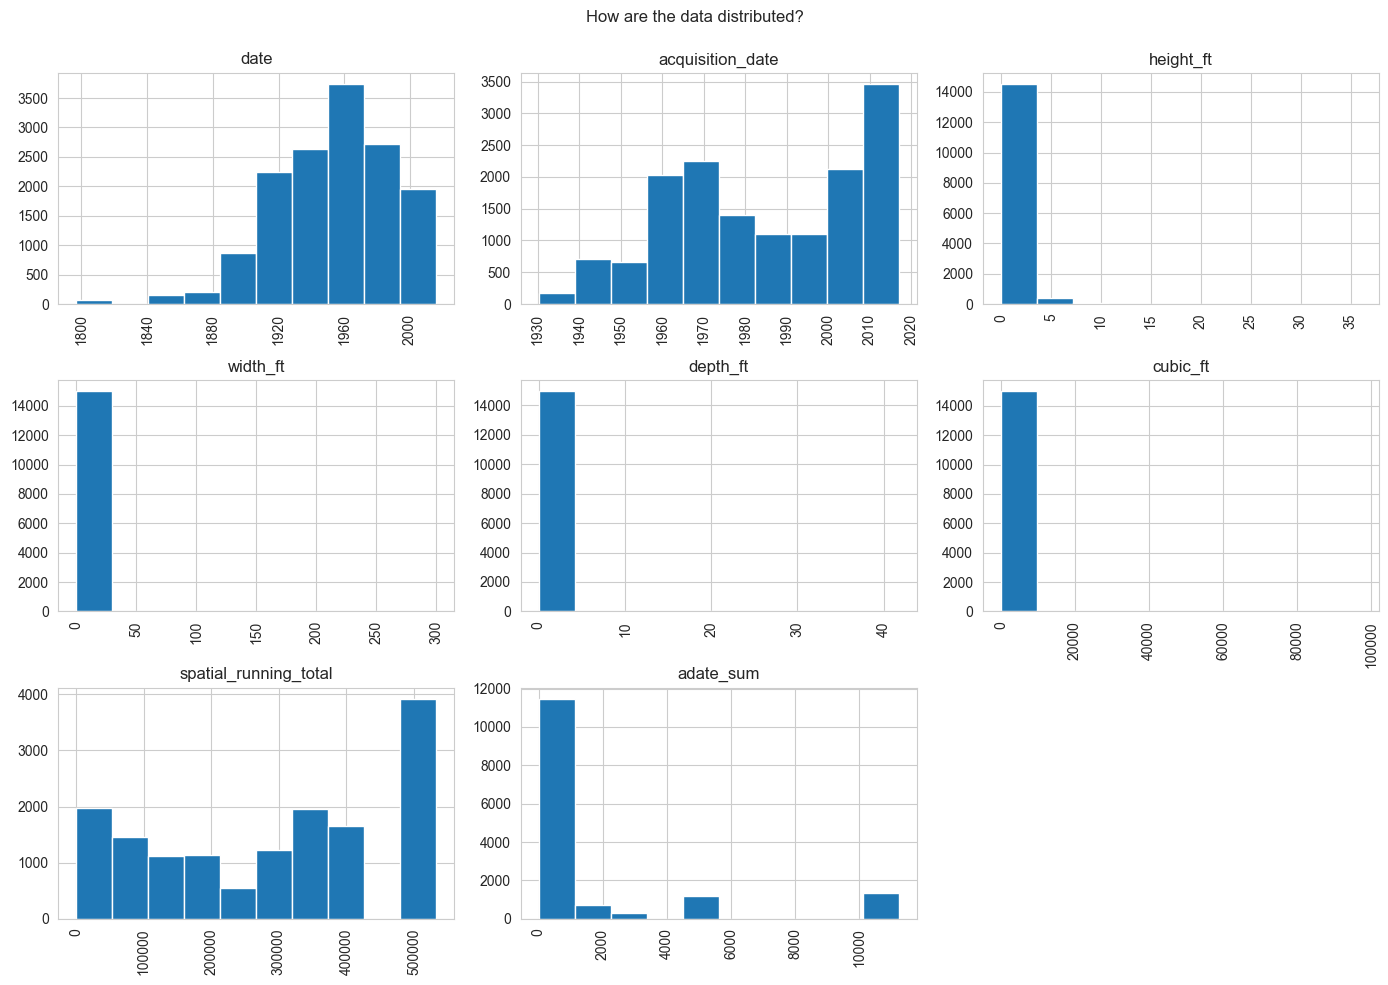

In [16]:
datasets["artworks_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

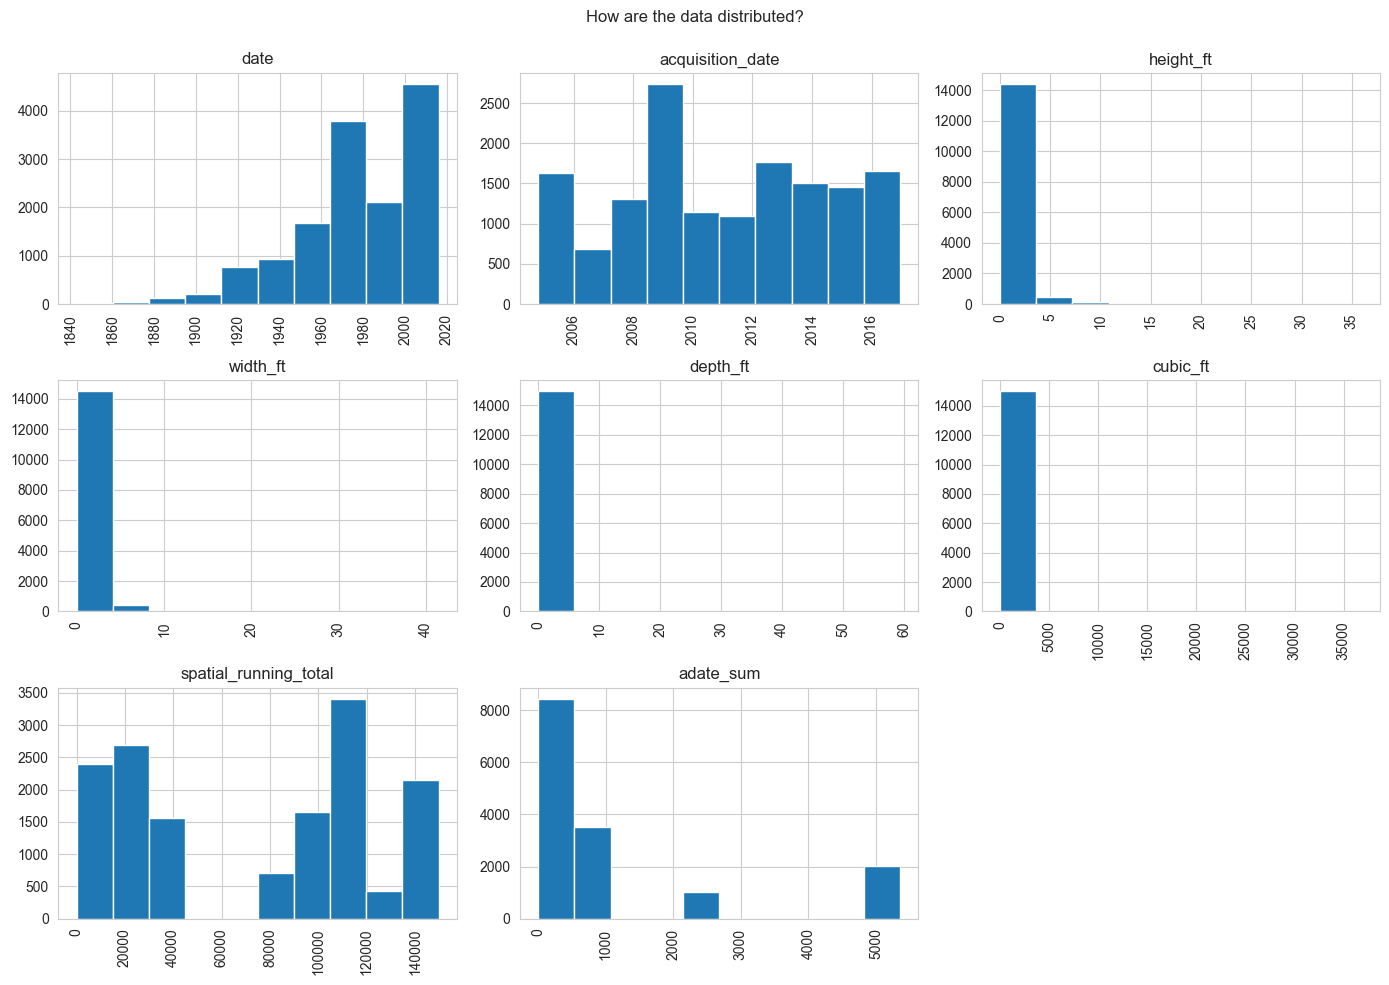

In [17]:
datasets["recent_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

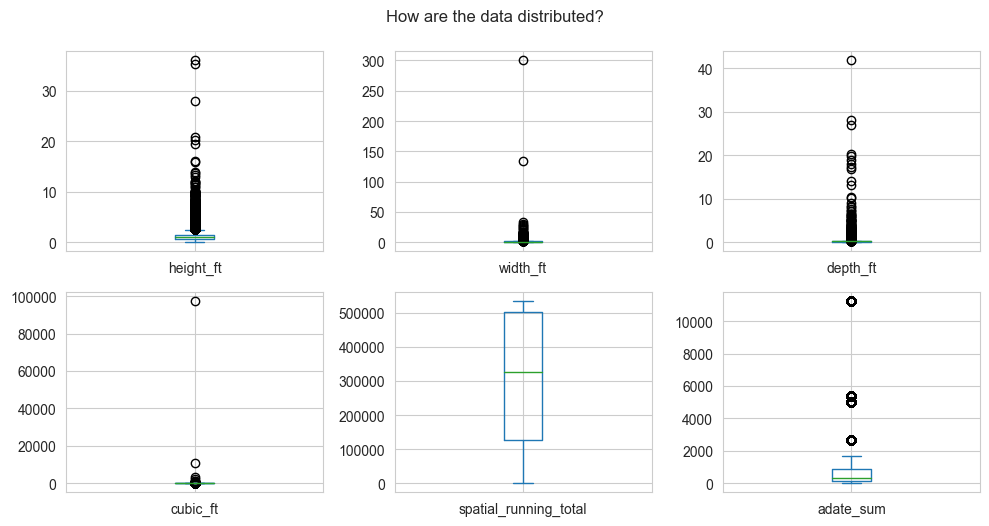

In [18]:
datasets["artworks_data"].plot(
    figsize=(10, 10), 
    kind="box", 
    subplots=True, 
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

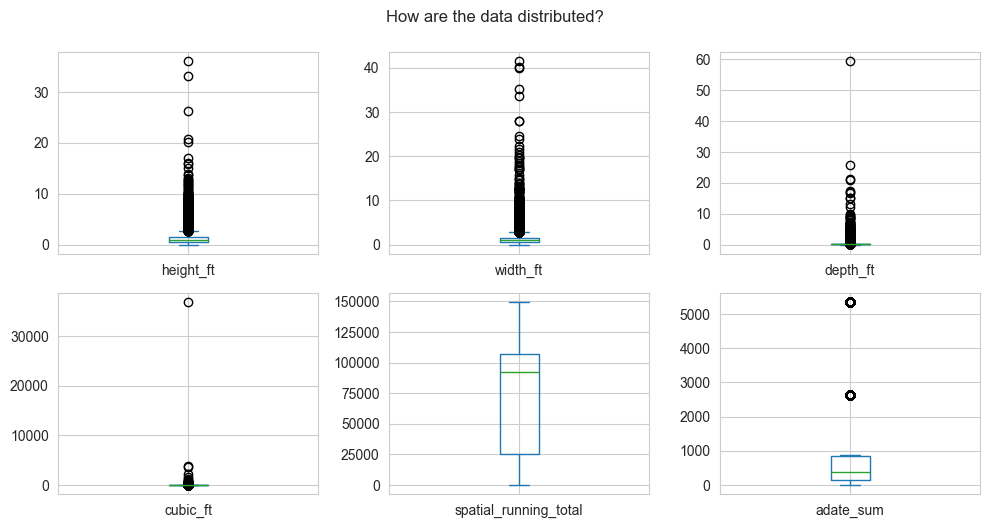

In [19]:
datasets["recent_data"].plot(
    figsize=(10, 10),
    kind="box",
    subplots=True,
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

In [20]:
# TODO: Display which Object Numbers are connected to spatial outliers
outliers = detect_IQR_outliers(datasets["artworks_data"][numerical_columns])

Columns which contain outliers outside of the 25th and 75th percentiles:
height_ft                 True
width_ft                  True
depth_ft                  True
cubic_ft                  True
spatial_running_total    False
adate_sum                 True
dtype: bool


In [21]:
ts_columns = pd.Index(["day_of_month", "day_of_year", "week_of_month", "week", "month", "year"])

datasets["artworks_data"].loc[:, numerical_columns] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))
datasets["artworks_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))

datasets["recent_data"].loc[:, numerical_columns] = remove_outliers(datasets["recent_data"].select_dtypes("number"))
datasets["recent_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["recent_data"].select_dtypes("number"))

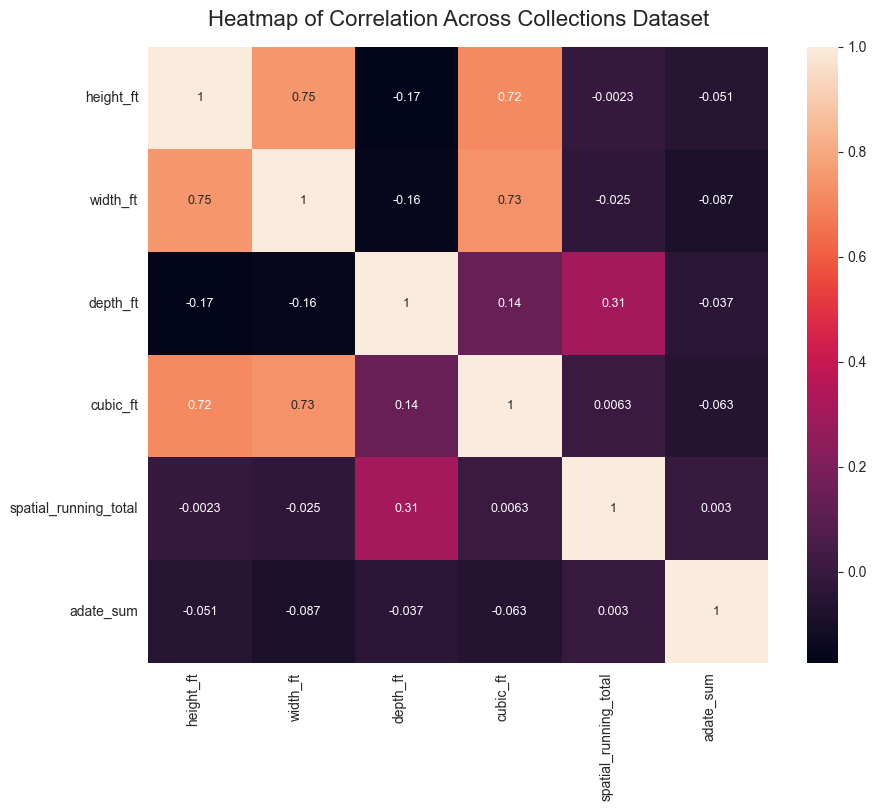

In [22]:
corr_matrix = datasets["artworks_data"].drop(columns=["acc_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

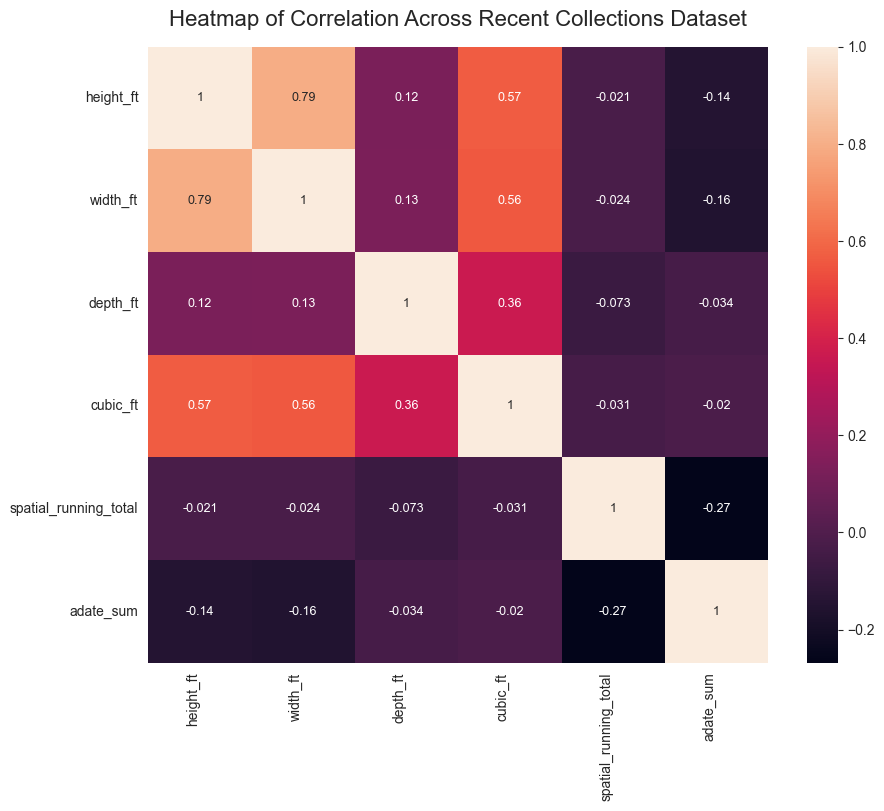

In [23]:
corr_matrix = datasets["recent_data"].corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Recent Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

<section id="ts-analysis">
    <h2>Collections Time Series Analysis</h2>
</section>

Explain here why I use the overall dataset and a subset of the overall dataset. Motivated by having the high-level perspective of overall data integrity, and a more nuanced view for interpreting more recent data for estimation purposes.
<br>

<section id="acc-analysis">
    <h3>Accessions Analysis & Decomposition</h3>
</section>

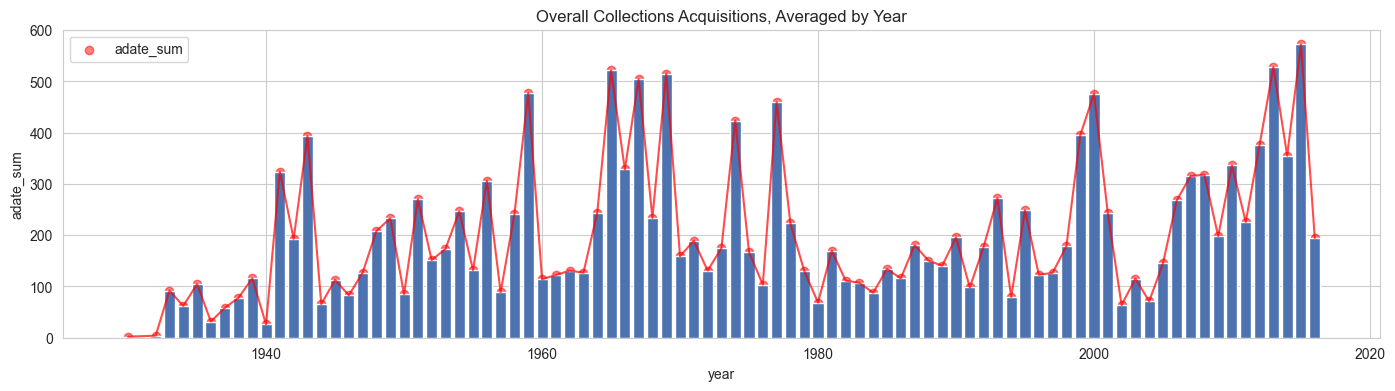

In [24]:
# Accession counts over all-time
yearly_means = datasets["artworks_tsdata"].groupby("year").mean(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.scatter(x = "year", y = "adate_sum", color = "red", marker = "o", data = yearly_means, alpha = 0.5)
plt.bar(x = "year", height = "adate_sum", color = sns.color_palette("deep")[0], data = yearly_means)
sns.lineplot(yearly_means, x = "year", y = "adate_sum", color = "red", alpha = 0.7)
plt.title("Overall Collections Acquisitions, Averaged by Year");
plt.show()
plt.close()

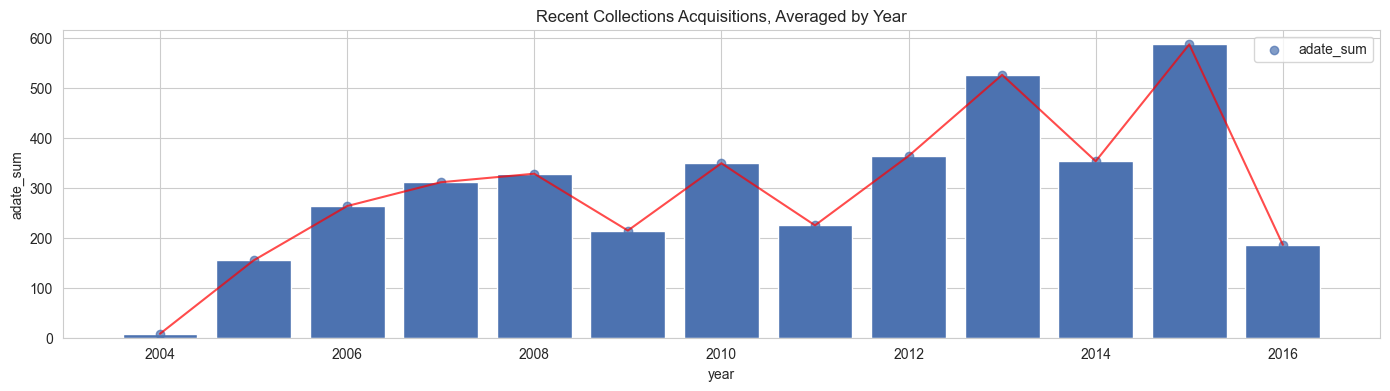

In [25]:
yearly_means = datasets["recent_tsdata"].groupby("year").mean(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.bar(x = "year", height = "adate_sum", color = sns.color_palette("deep")[0], data = yearly_means)
plt.scatter(x = "year", y = "adate_sum", color = sns.color_palette("deep")[0], marker = "o", data = yearly_means, alpha = 0.7)
sns.lineplot(yearly_means, x = "year", y = "adate_sum", color = "red", alpha = 0.7)
plt.title("Recent Collections Acquisitions, Averaged by Year");
plt.show()
plt.close()

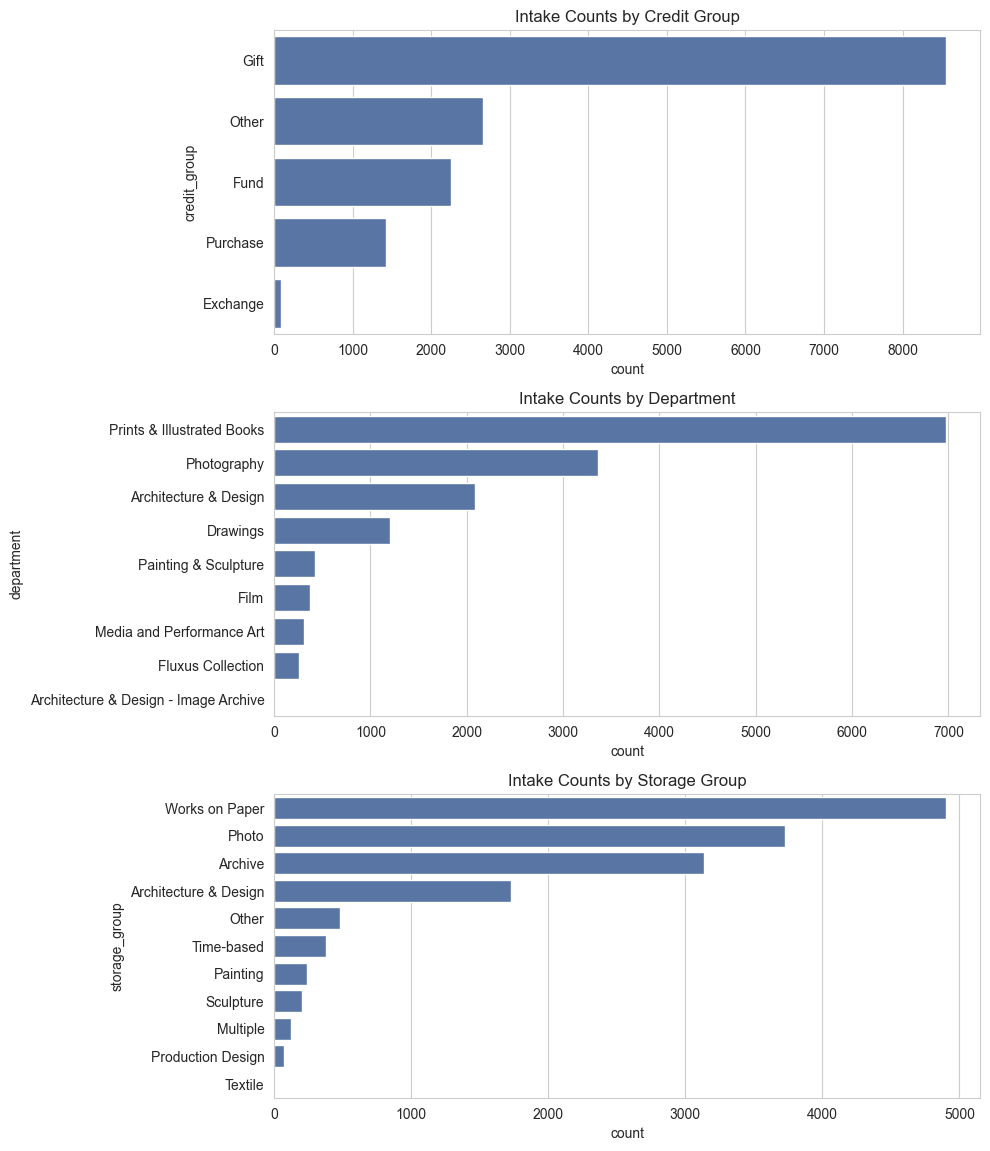

In [26]:
# Overall accession counts by credit, department, and storage group
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["artworks_data"],
        # sorts plots by descending order for visual clarity
        order = datasets["artworks_data"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

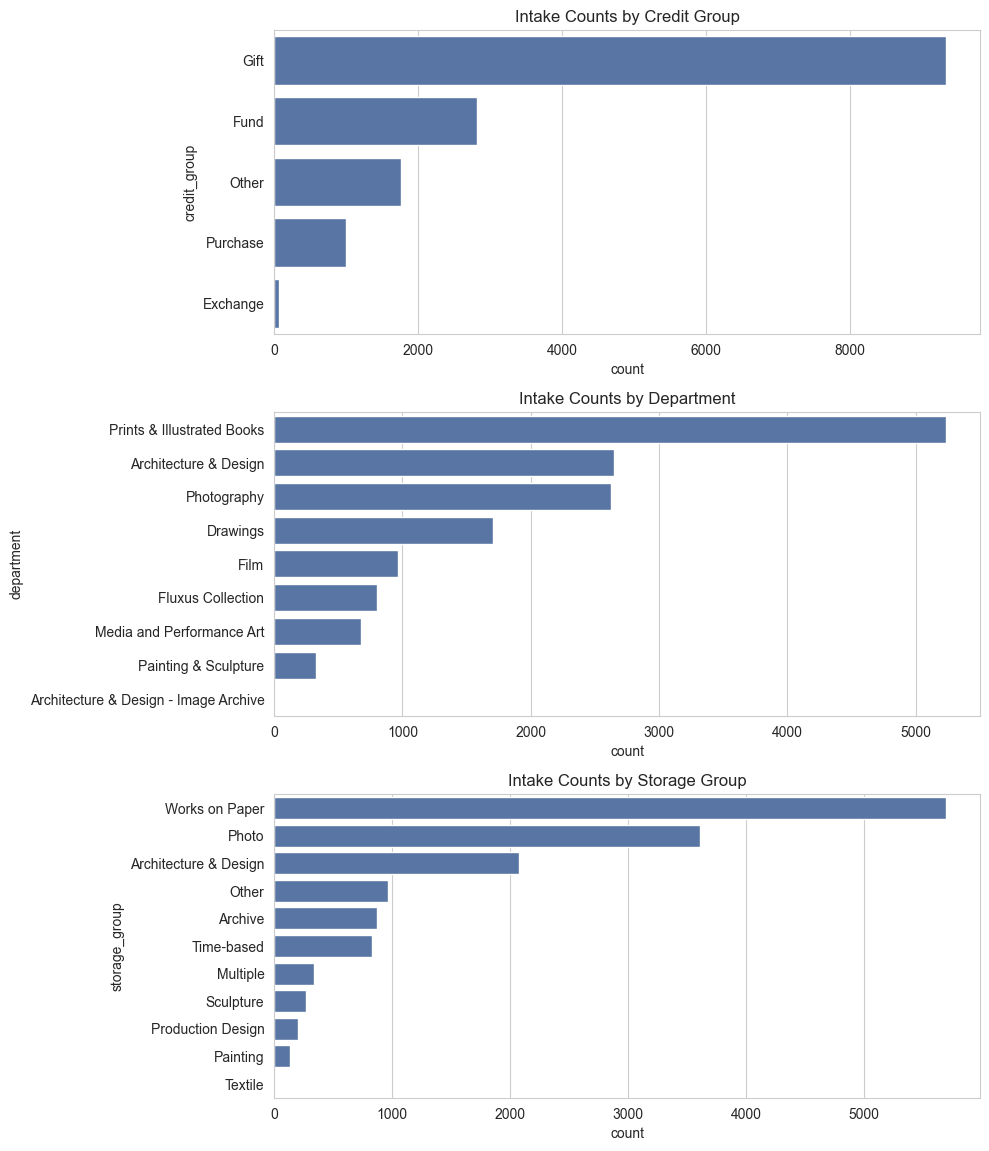

In [27]:
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["recent_tsdata"],
        # sorts plots by descending order for visual clarity
        order = datasets["recent_data"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

<section id="gap-analysis">
    <h2>Time Series Analysis of Acquisition Counts</h2>
</section>

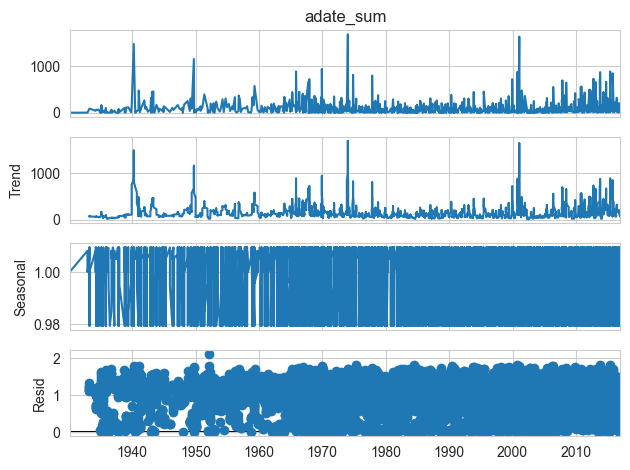

In [28]:
ts_data = (datasets["artworks_data"]
           .set_index("acquisition_date")
           .sort_index()
           ["adate_sum"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="multiplicative", period = 12)
decomposition.plot();

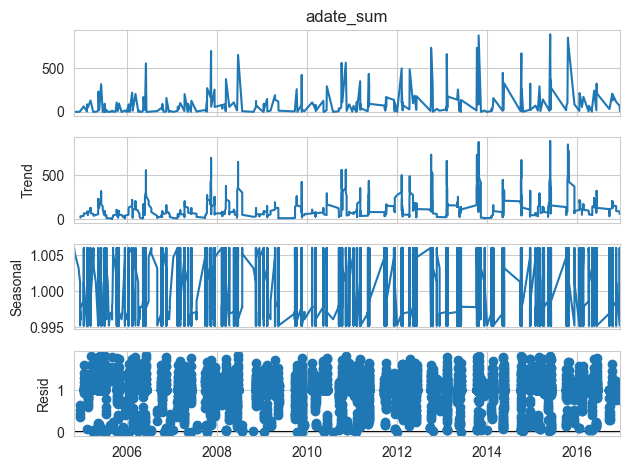

In [29]:
ts_data = (datasets["recent_data"]
           .set_index("acquisition_date")
           .sort_index()
           ["adate_sum"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="multiplicative", period = 12)
decomposition.plot();

c:\Users\lilyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


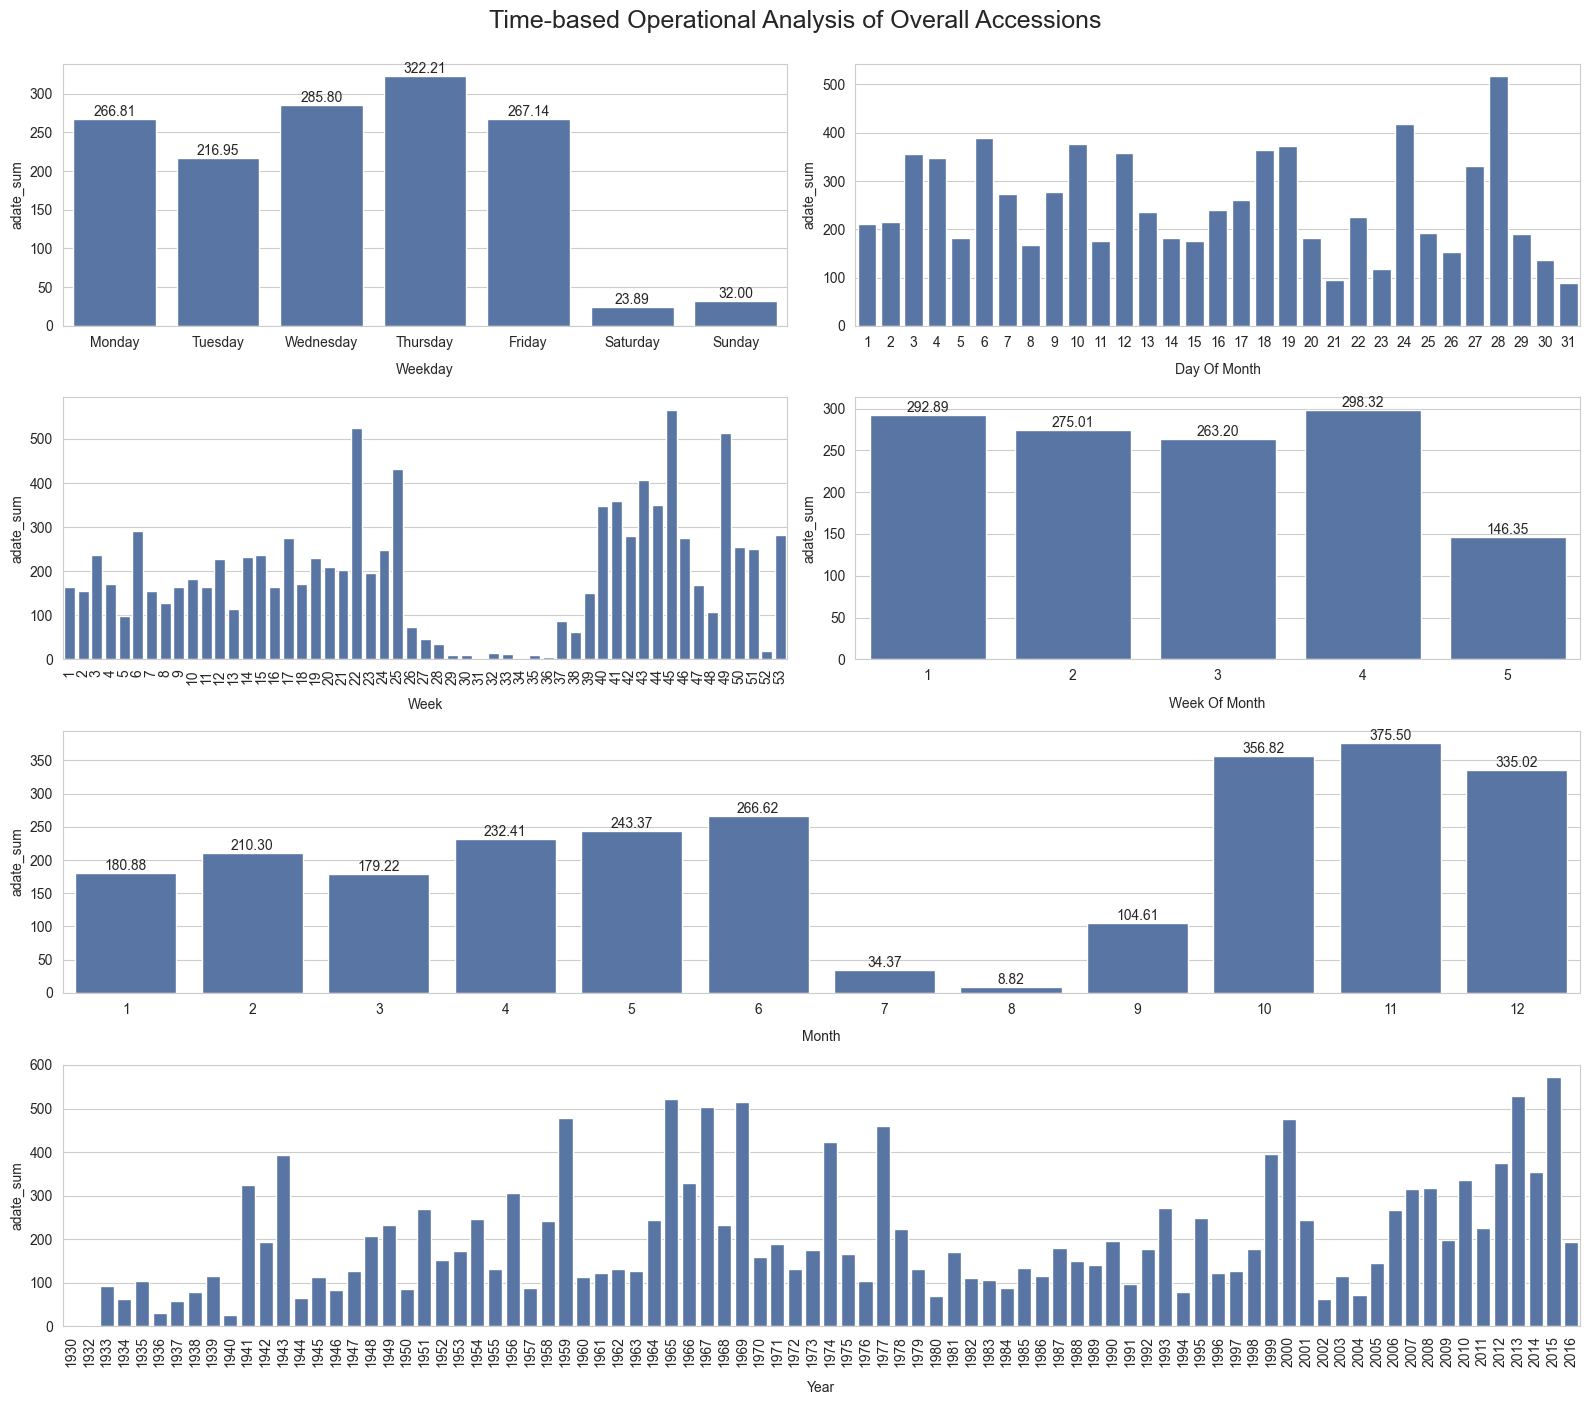

In [30]:
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Time-based Operational Analysis of Overall Accessions", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["artworks_tsdata"], x = column, y = "adate_sum", ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    if len(datasets["artworks_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "month", y = "adate_sum", ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax.set_xlabel("month".title(), labelpad = 10)
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "year", y = "adate_sum", ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax2.set_xlabel("year".title(), labelpad = 10)

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

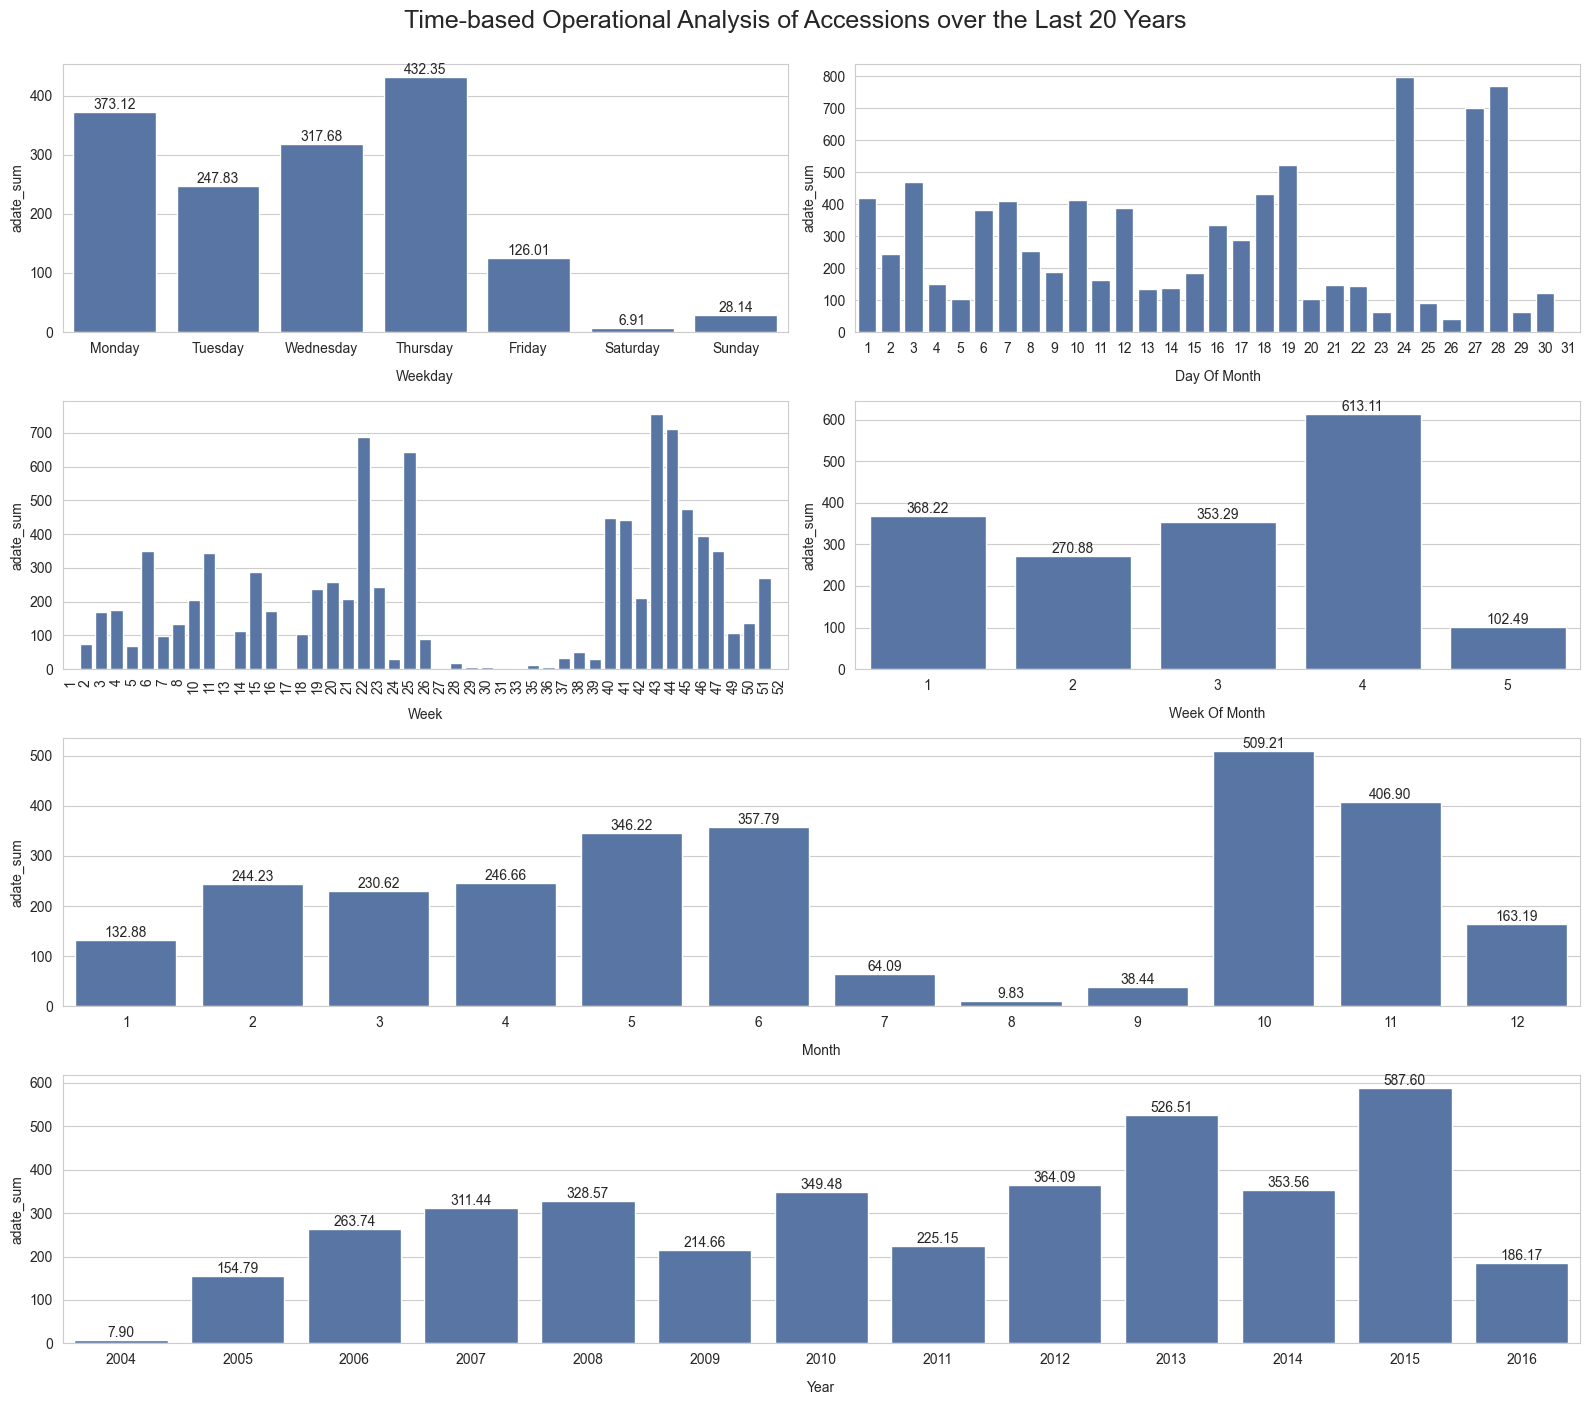

In [31]:
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Time-based Operational Analysis of Accessions over the Last 20 Years", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["recent_tsdata"], x = column, y = "adate_sum", ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    if len(datasets["recent_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "month", y = "adate_sum", ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax.set_xlabel("month".title(), labelpad = 10)
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "year", y = "adate_sum", ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax2.set_xlabel("year".title(), labelpad = 10)
for p in combined_ax2.patches:
    combined_ax2.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
# combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

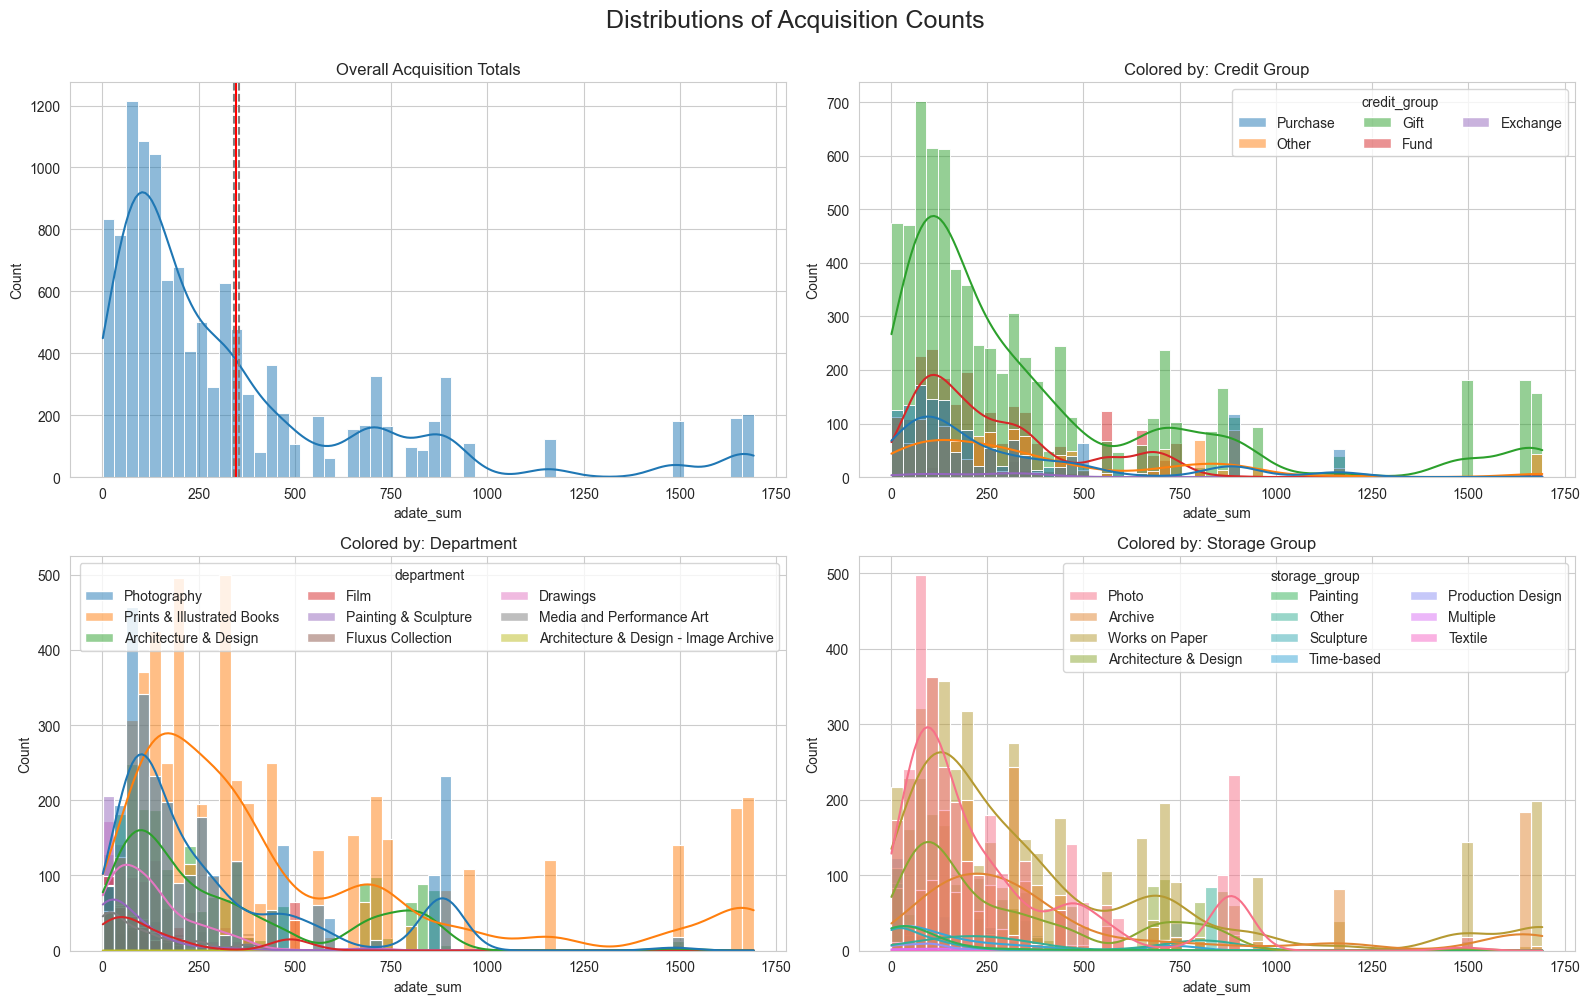

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["artworks_data"], "adate_sum")
sns.histplot(data=datasets["artworks_data"], x = "adate_sum", kde = True, ax = axs[0, 0])
axs[0, 0].axvline(np.mean(datasets["artworks_data"]["adate_sum"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Totals")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["artworks_data"], x = "adate_sum", hue = column, kde = True, ax = ax)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

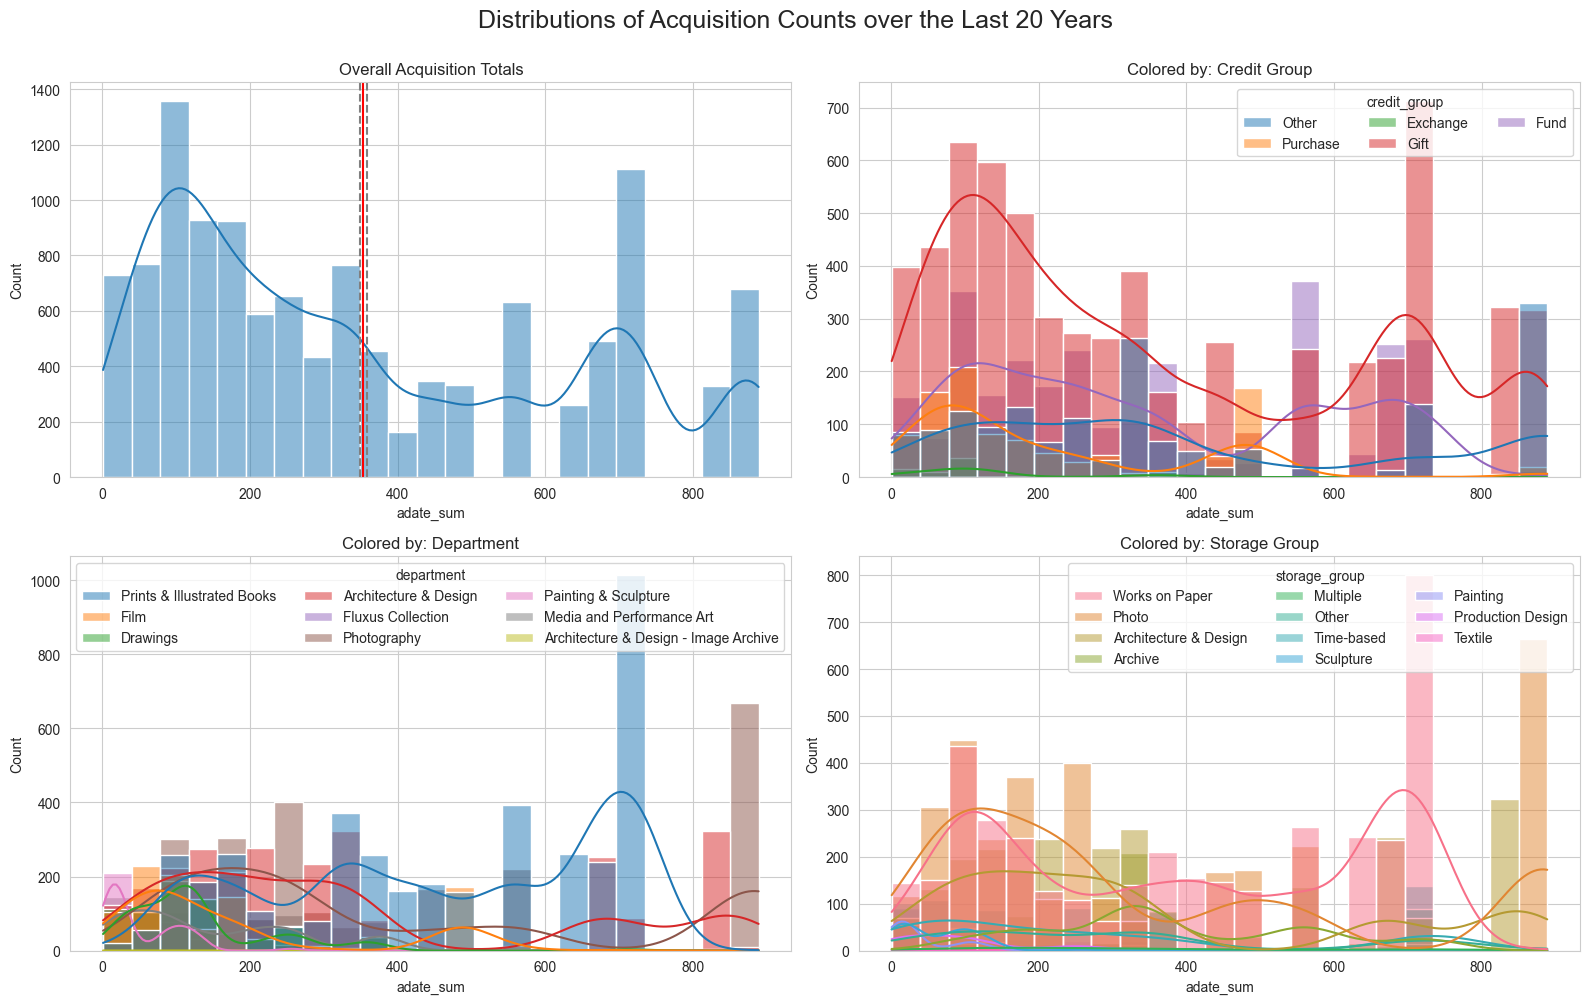

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts over the Last 20 Years", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["recent_data"], "adate_sum")
sns.histplot(data=datasets["recent_data"], x = "adate_sum", kde = True, ax = axs[0, 0])
axs[0, 0].axvline(np.mean(datasets["recent_data"]["adate_sum"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Totals")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["recent_data"], x = "adate_sum", hue = column, kde = True, ax = ax)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

Text(0.5, 1.0, 'Date of Works plotted against Acquisition Dates')

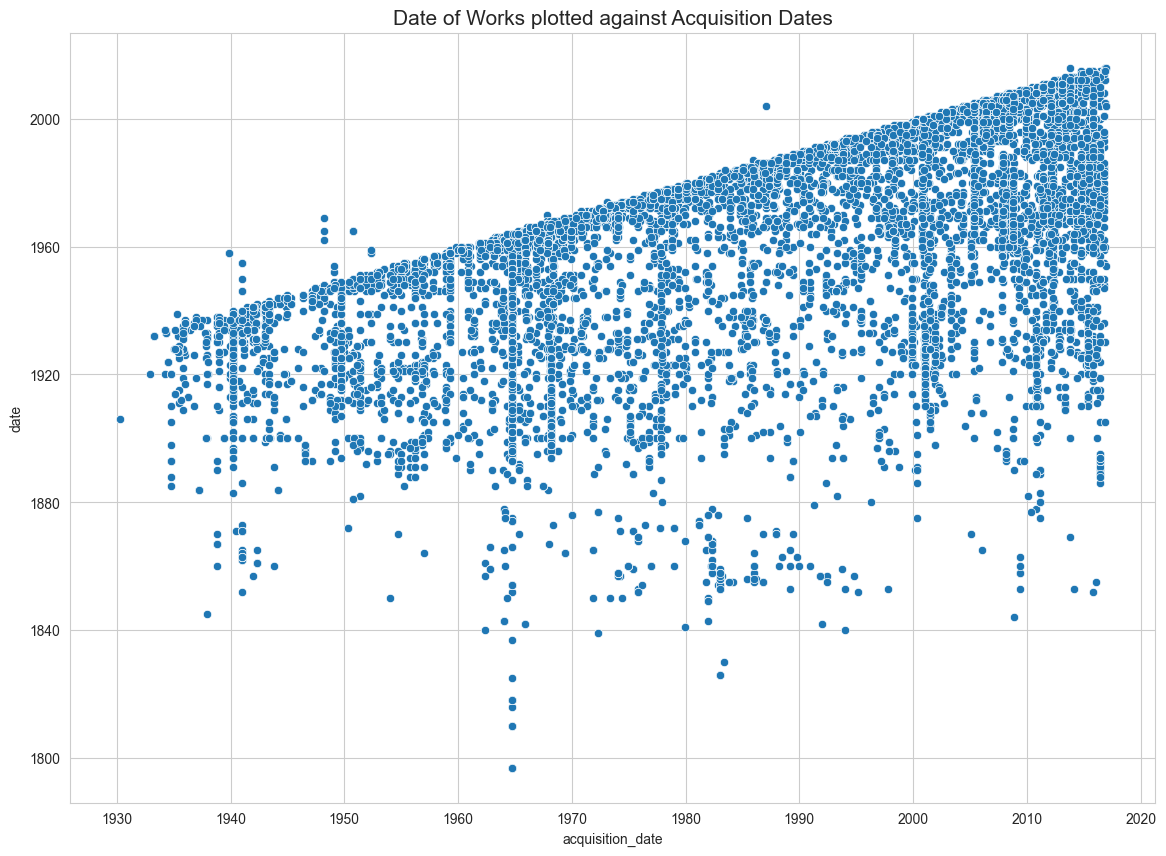

In [34]:
# Table: How contemporary are the intake practices of the NYC MoMA?
plt.figure(figsize = (14, 10))
sns.scatterplot(datasets["artworks_tsdata"], x = "acquisition_date", y = "date")
plt.title("Date of Works plotted against Acquisition Dates", fontsize = 15, y = 1.0)

<section id="spatial-stats">
    <h2>Spatial Descriptive Statistics - Histograms, Boxplots, and Totals by [Overall, Credit, Dept, Storage_Group]</h2>
</section>

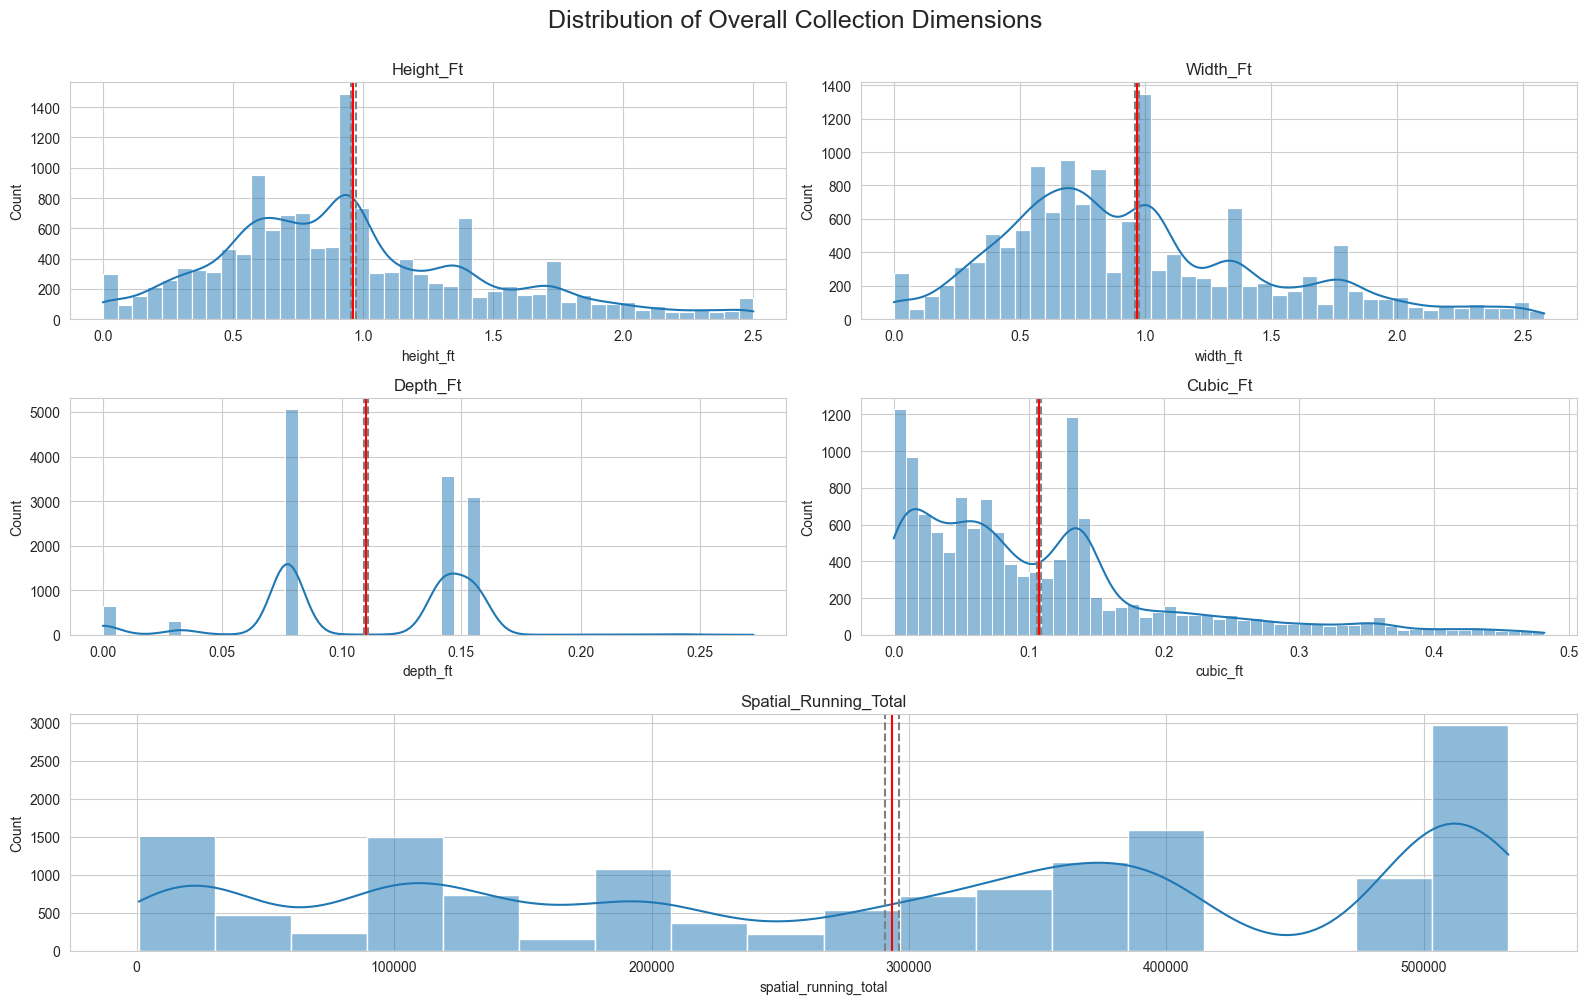

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))
plt.suptitle(f"Distribution of Overall Collection Dimensions", fontsize = 18, y = 1.0)

for i, column in enumerate(spatial_columns[:-1]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    ci = calculate_confidence_intervals_95(datasets["artworks_data"], column)
    sns.histplot(data=datasets["artworks_data"], x = column, ax = ax, kde = True)
    ax.axvline(np.mean(datasets["artworks_data"][column]), color = "red")
    ax.axvline(ci[0], color="gray", linestyle = "--")
    ax.axvline(ci[1], color="gray", linestyle = "--")
    ax.set_title(column.title())
axs[2, 1].remove()
axs[2, 0].remove()

combined_ax = fig.add_subplot(3, 1, 3)  # combined plot row
sns.histplot(data = datasets["artworks_data"], x = "spatial_running_total", ax = combined_ax, kde = True)
ci = calculate_confidence_intervals_95(datasets["artworks_data"], "spatial_running_total")
combined_ax.axvline(np.mean(datasets["artworks_data"]["spatial_running_total"]), color="red")
combined_ax.axvline(ci[0], color="gray", linestyle = "--")
combined_ax.axvline(ci[1], color="gray", linestyle = "--")
combined_ax.set_title("spatial_running_total".title())
plt.tight_layout()
plt.show()
plt.close(fig)

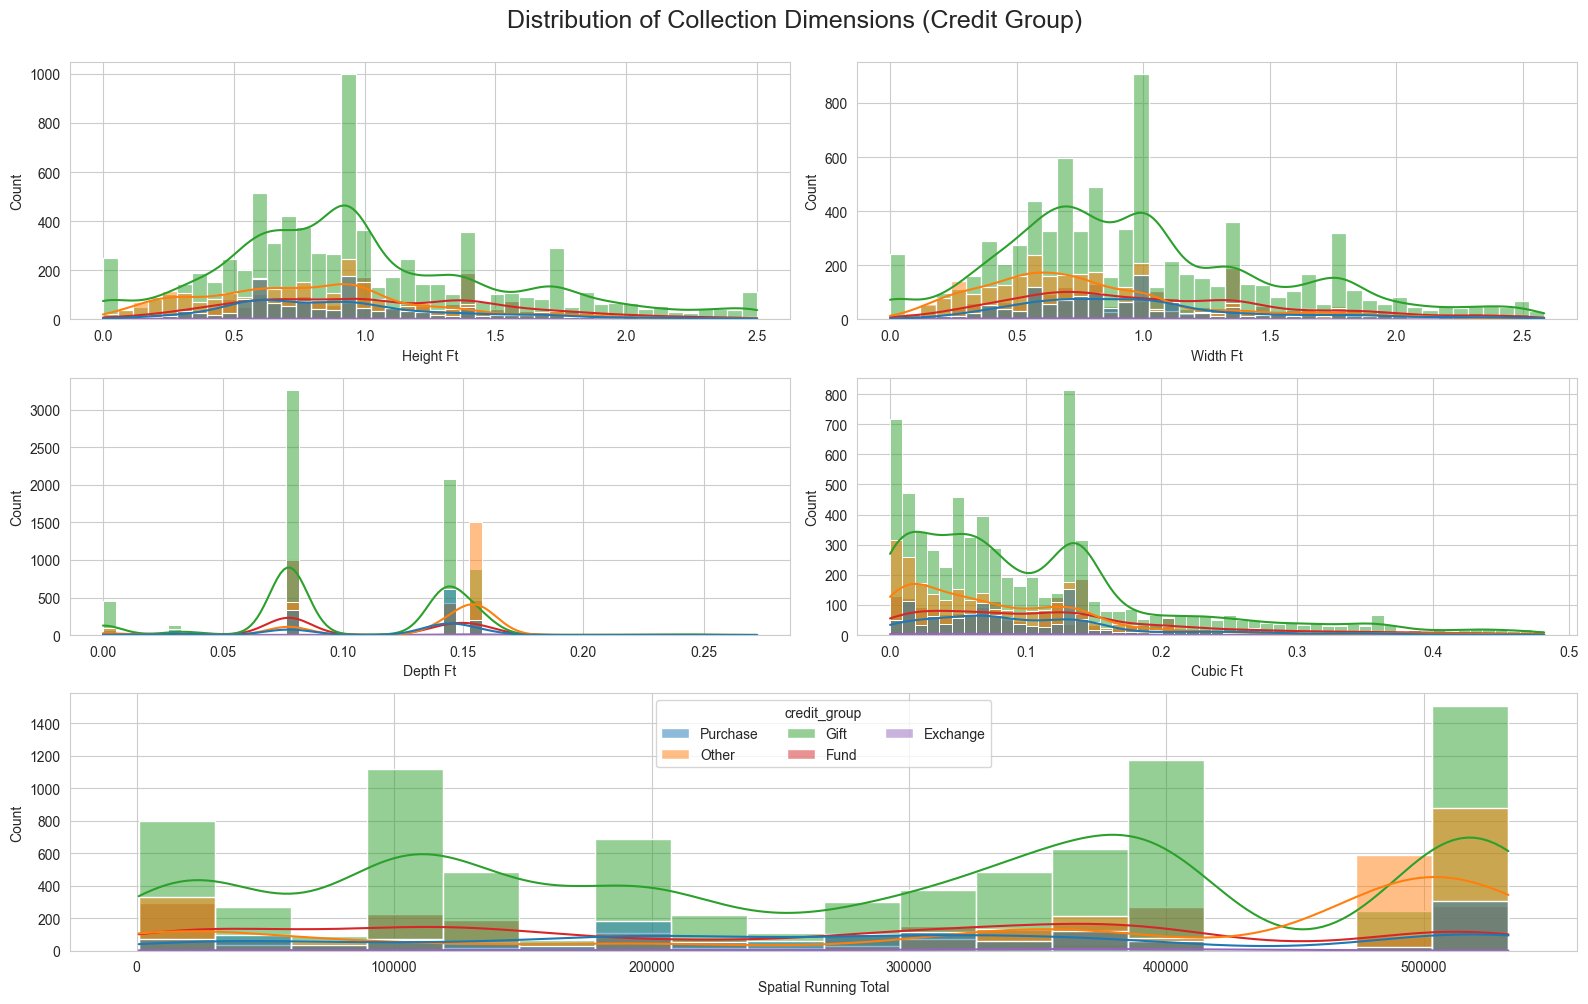

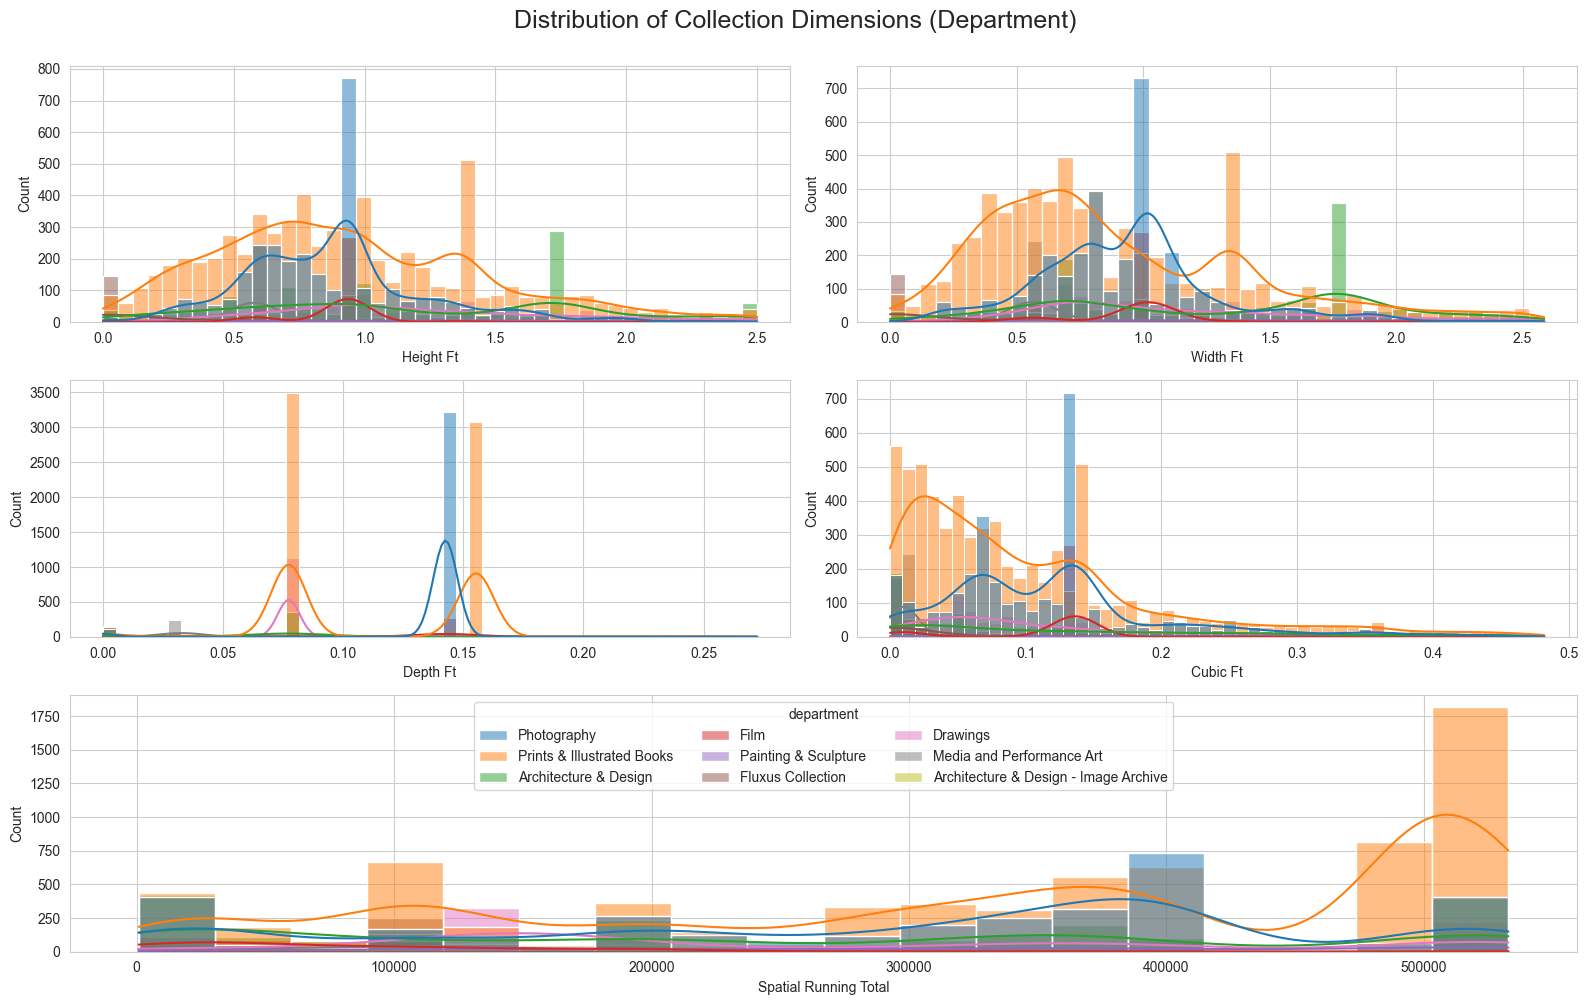

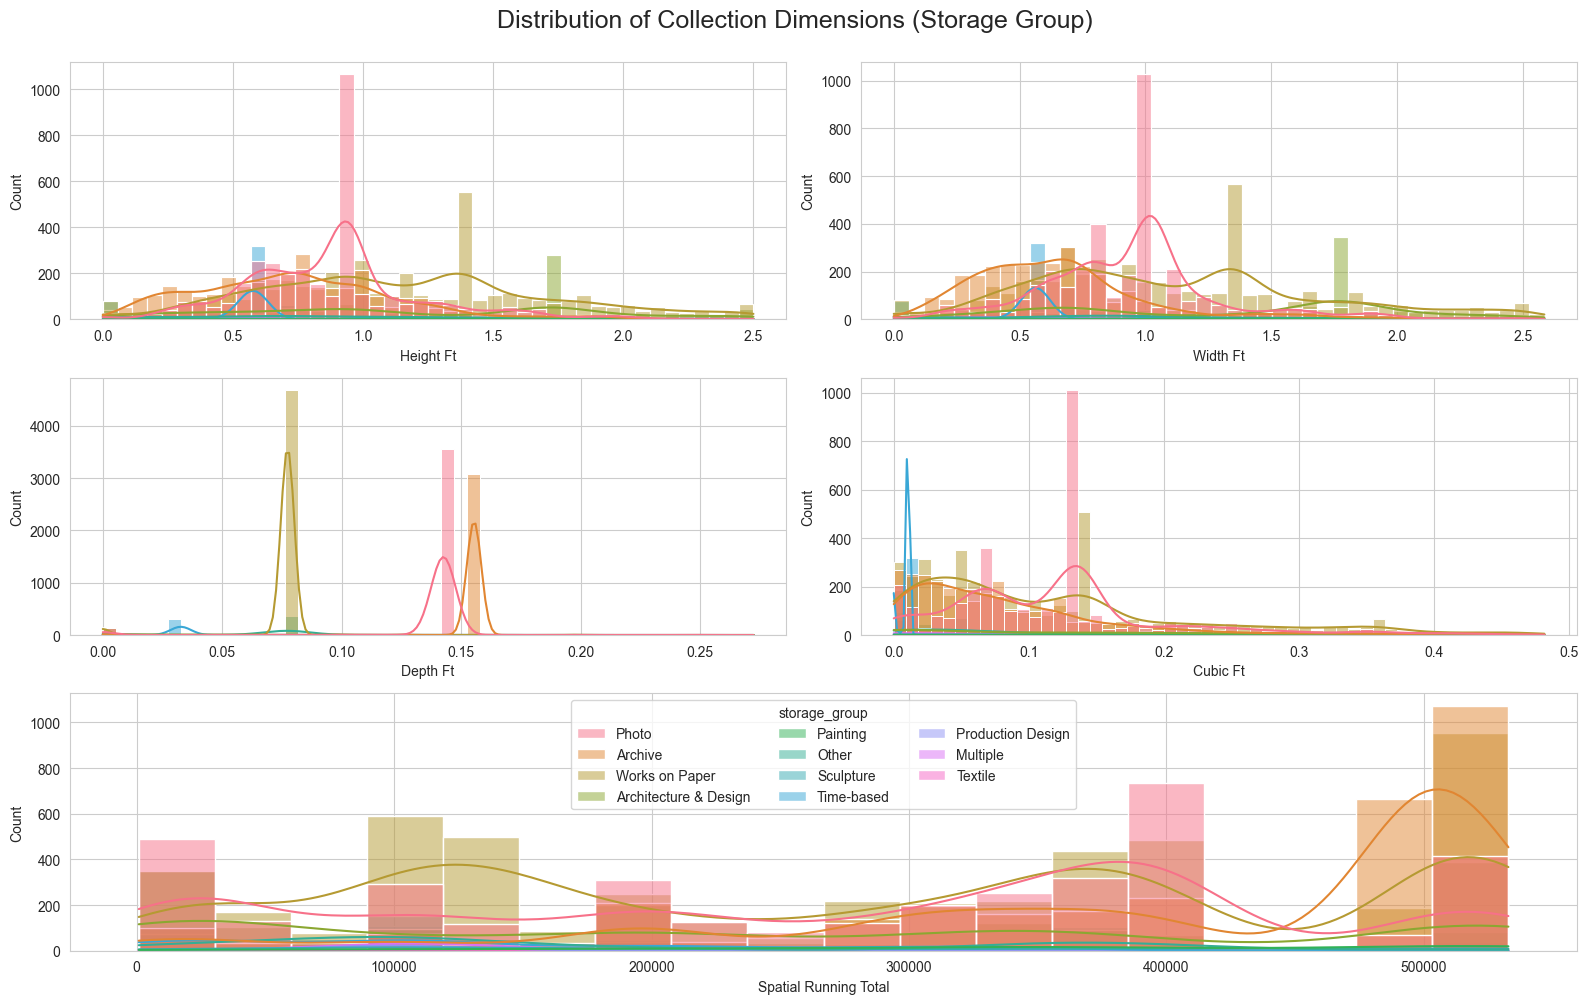

In [36]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Distribution of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.histplot(data=datasets["artworks_data"], 
                     x = column, hue = category,
                     ax = ax, kde = True, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.histplot(data = datasets["artworks_data"], x = "spatial_running_total", hue = category, ax = combined_ax, kde = True)
    sns.move_legend(combined_ax, loc = "upper center", ncol = 3)
    combined_ax.set_xlabel("spatial running total".title())
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [37]:
# Spatial totals by department and storage group
# fig, axs = plt.subplots(3, 2, figsize=(16, 10))
# data = datasets["artworks_data"].groupby("department").sum()
# plt.suptitle(f"Totals of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

# for i, column in enumerate(spatial_columns[:-1]):
#     for idx, column in enumerate(spatial_columns, 1):
#         ax = axs[i // 2, i % 2]  # Calculate row and column index
#         # Acquistion date counts
#         # plt.subplot(4, 1, idx)
#         sns.countplot(
#             y = column,
#             data = data,
#             # sorts plots by descending order for visual clarity
#             # order = datasets["artworks_data"][column].sum(),
#             color = sns.color_palette("deep")[0]
#         )
#         plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
# plt.tight_layout()
# plt.show()

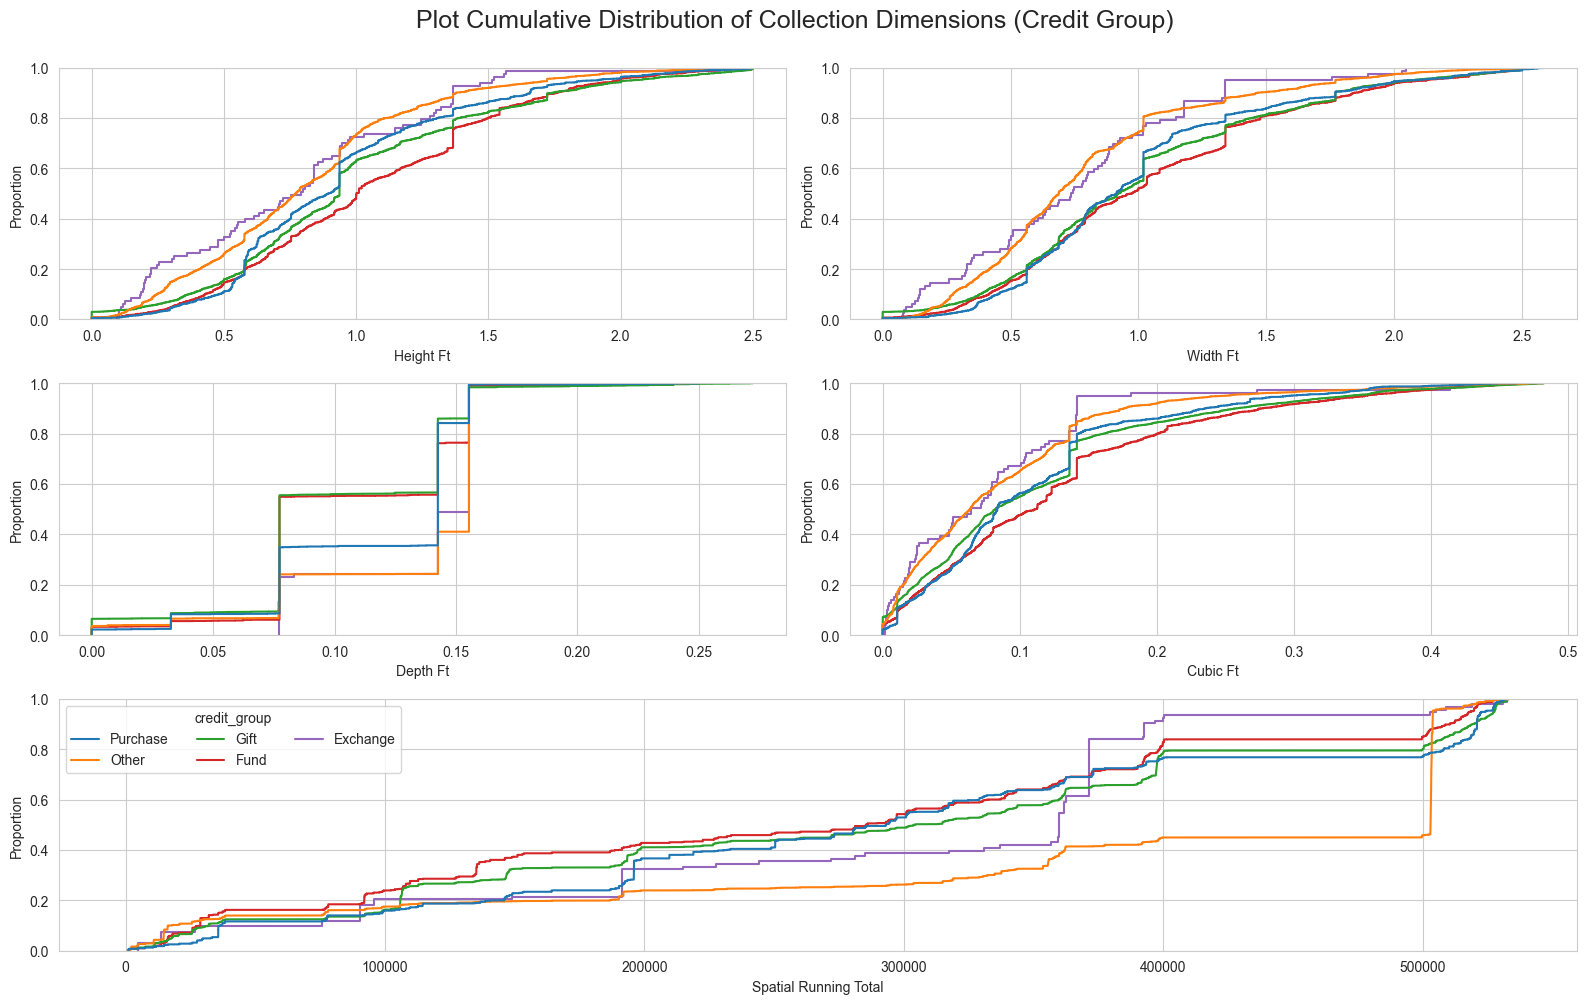

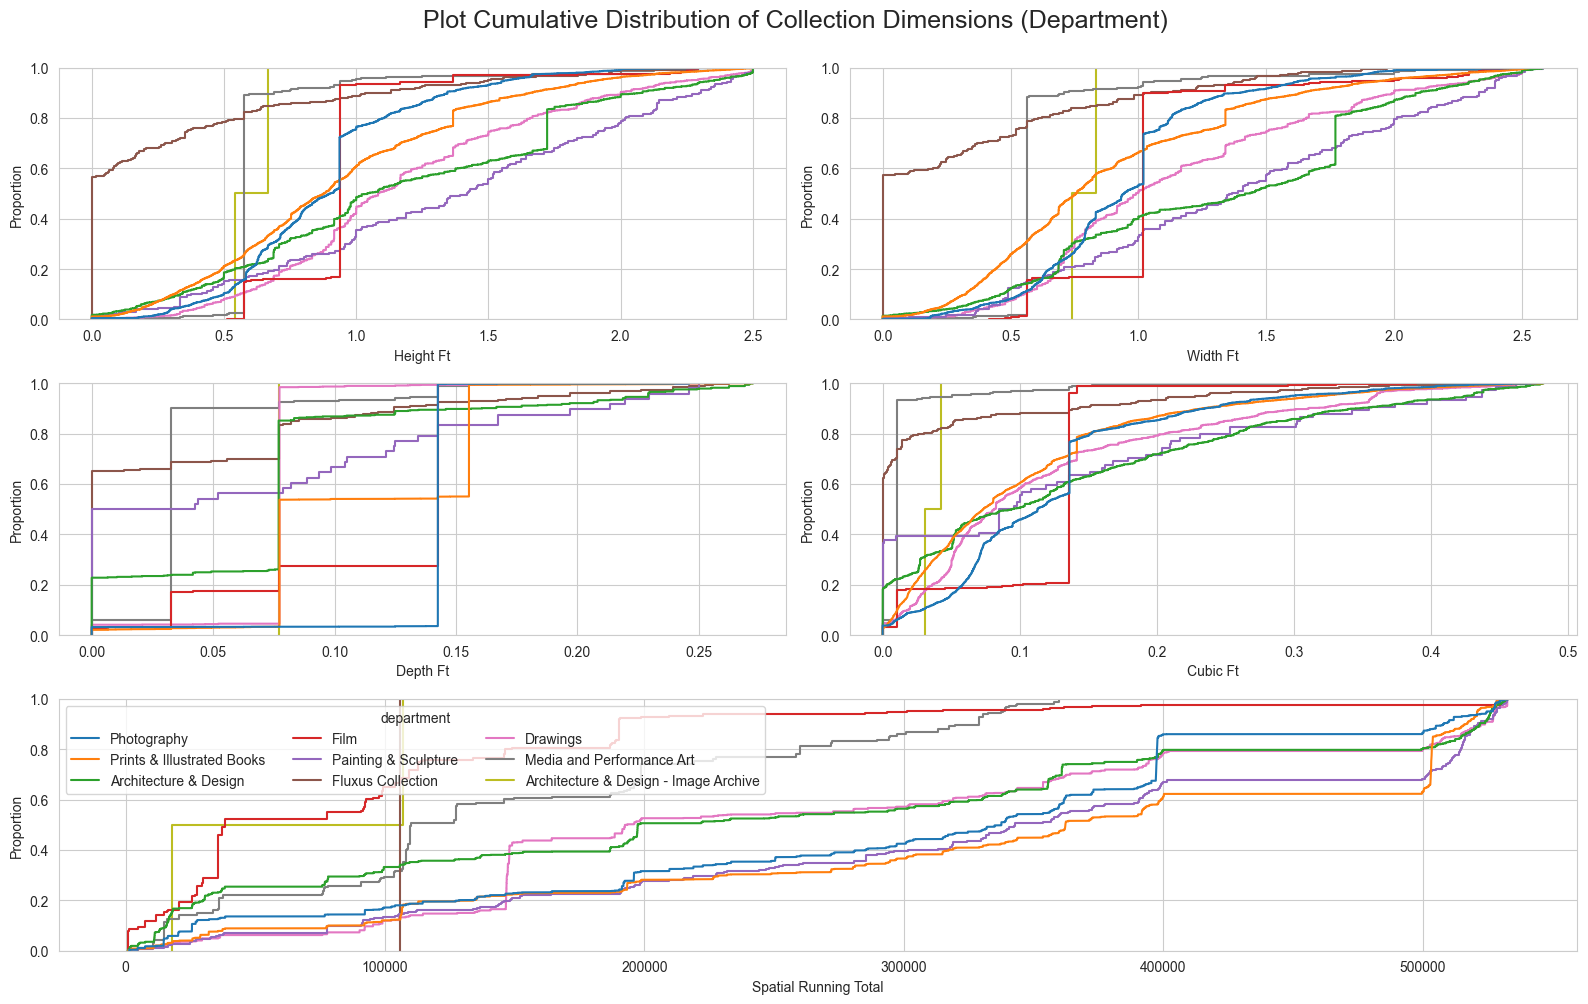

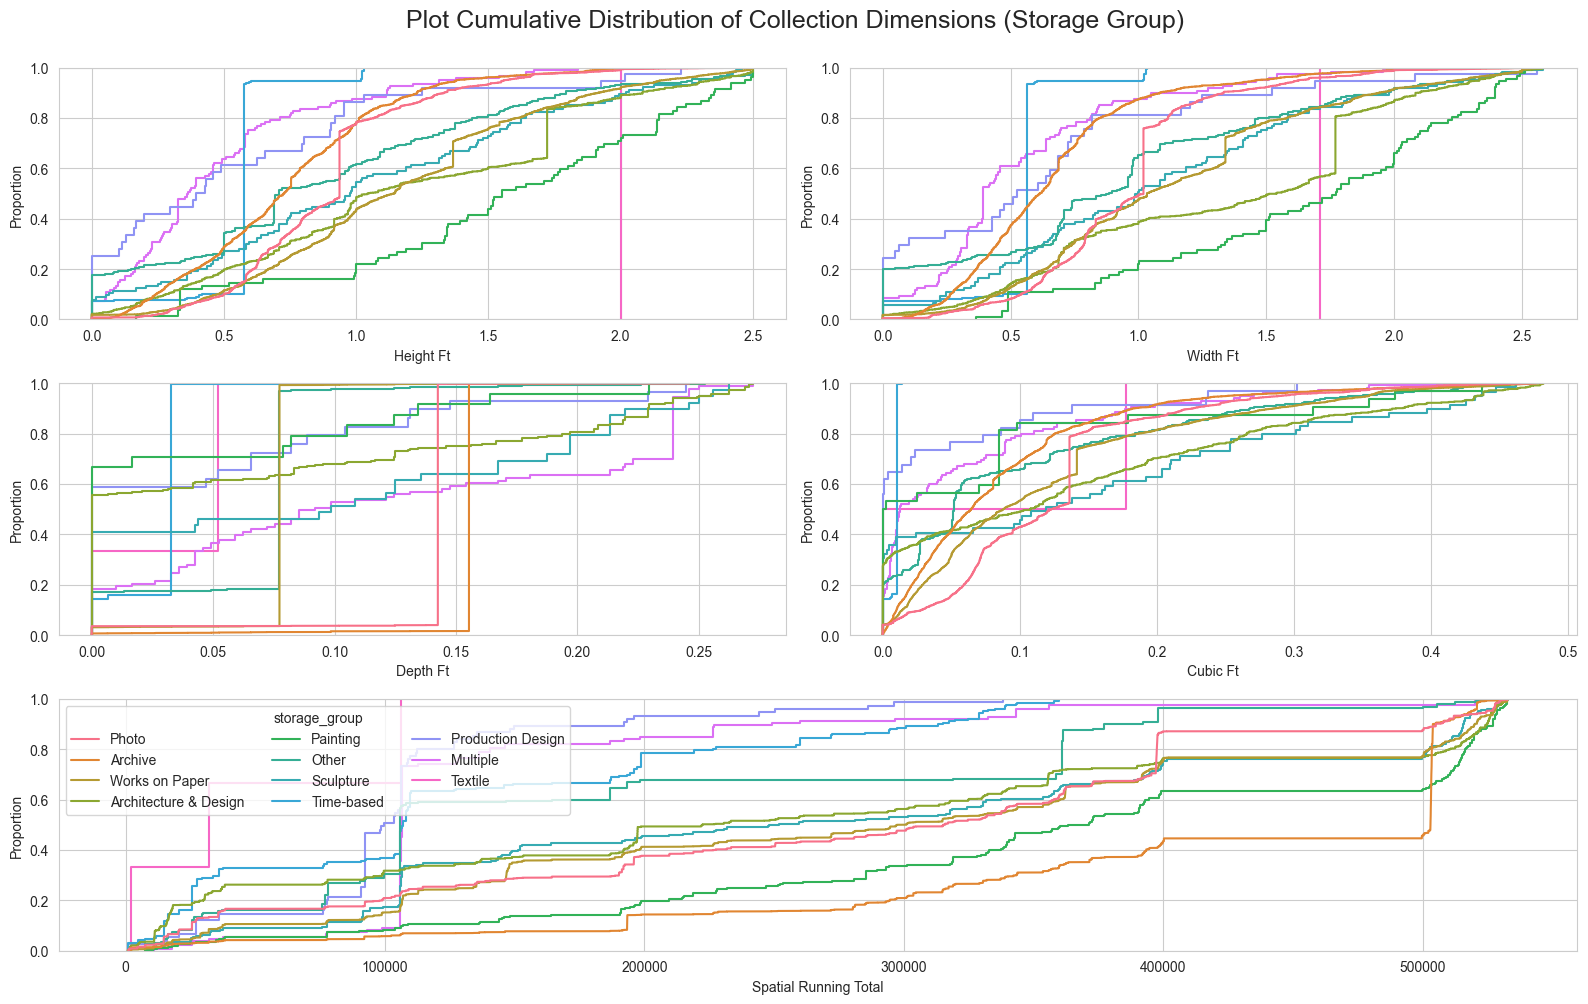

In [38]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Plot Cumulative Distribution of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.ecdfplot(data=datasets["artworks_data"], 
                     x = column, hue = category,
                     ax = ax, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.ecdfplot(data = datasets["artworks_data"], x = "spatial_running_total", hue = category, ax = combined_ax)
    combined_ax.set_xlabel("spatial running total".title())
    sns.move_legend(combined_ax, loc = "upper left", ncol = 3)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [39]:
(datasets["artworks_data"]
 .groupby("department")
 .describe()  # Descriptive Statistics Table by Department
 .T  # Transpose for a nice view
 )

department                   Architecture & Design  \
height_ft             count               1692.000   
                      mean                   1.179   
                      std                    0.657   
                      min                    0.000   
                      25%                    0.688   
                      50%                    1.042   
                      75%                    1.722   
                      max                    2.500   
width_ft              count               1716.000   
                      mean                   1.304   
                      std                    0.650   
                      min                    0.000   
                      25%                    0.699   
                      50%                    1.427   
                      75%                    1.770   
                      max                    2.585   
depth_ft              count                606.000   
                      mean                   0.075   
                      std                    0.061   
                      min                    0.000   
                      25%                    0.049   
                      50%                    0.077   
                      75%                    0.077   
                      max                    0.272   
cubic_ft              count                851.000   
                      mean                   0.134   
                      std                    0.134   
                      min                    0.000   
                      25%                    0.025   
                      50%                    0.094   
                      75%                    0.222   
                      max                    0.482   
spatial_running_total count               2088.000   
                      mean              244689.749   
                      std               186128.234   
                      min                  816.089   
                      25%                38260.060   
                      50%               197420.654   
                      75%               389721.880   
                      max               532767.900   
adate_sum             count               2073.000   
                      mean                 315.072   
                      std                  284.604   
                      min                    1.000   
                      25%                   93.000   
                      50%                  215.000   
                      75%                  460.000   
                      max                 1484.000   

department                   Architecture & Design - Image Archive   Drawings  \
height_ft             count                                  2.000   1085.000   
                      mean                                   0.604      1.197   
                      std                                    0.088      0.541   
                      min                                    0.542      0.000   
                      25%                                    0.573      0.833   
                      50%                                    0.604      1.083   
                      75%                                    0.635      1.522   
                      max                                    0.667      2.500   
width_ft              count                                  2.000   1083.000   
                      mean                                   0.786      1.150   
                      std                                    0.066      0.571   
                      min                                    0.740      0.000   
                      25%                                    0.763      0.708   
                      50%                                    0.786      0.991   
                      75%                                    0.810      1.509   
                      max                                

In [40]:
(datasets["artworks_data"]
 .groupby("storage_group")
 .describe()  # Descriptive Statistics Table by Storage Group / Type
 .T  # Transpose for a nice view
 )

storage_group                Architecture & Design    Archive   Multiple  \
height_ft             count               1379.000   3125.000    121.000   
                      mean                   1.185      0.739      0.481   
                      std                    0.676      0.388      0.406   
                      min                    0.000      0.000      0.000   
                      25%                    0.667      0.469      0.203   
                      50%                    1.043      0.728      0.364   
                      75%                    1.722      0.978      0.591   
                      max                    2.500      2.500      1.837   
width_ft              count               1452.000   3113.000    120.000   
                      mean                   1.317      0.661      0.540   
                      std                    0.666      0.380      0.420   
                      min                    0.000      0.000      0.000   
                      25%                    0.692      0.410      0.300   
                      50%                    1.540      0.614      0.394   
                      75%                    1.770      0.794      0.693   
                      max                    2.585      2.559      1.998   
depth_ft              count                248.000   3131.000     93.000   
                      mean                   0.072      0.154      0.122   
                      std                    0.096      0.015      0.098   
                      min                    0.000      0.000      0.000   
                      25%                    0.000      0.155      0.036   
                      50%                    0.000      0.155      0.092   
                      75%                    0.148      0.155      0.240   
                      max                    0.272      0.197      0.272   
cubic_ft              count                564.000   3072.000    115.000   
                      mean                   0.137      0.086      0.062   
                      std                    0.144      0.083      0.091   
                      min                    0.000      0.000      0.000   
                      25%                    0.000      0.027      0.005   
                      50%                    0.108      0.064      0.013   
                      75%                    0.238      0.117      0.089   
                      max                    0.482      0.474      0.454   
spatial_running_total count               1731.000   3135.000    124.000   
                      mean              251331.054 399747.459 138801.786   
                      std               190353.774 141817.468  91585.635   
                      min                  816.089   1047.275  10829.402   
                      25%                37211.828 317260.109 105925.869   
                      50%               222394.858 503003.257 106498.051   
                      75%               399062.458 503470.310 127480.612   
                      max               532767.900 532715.777 520083.024   
adate_sum             count               1731.000   1798.000     44.000   
                      mean                 296.943    471.548    282.500   
                      std                  278.771    476.524    237.567   
                      min                    1.000     13.000      4.000   
                      25%                   86.000    167.000     89.000   
                      50%                  172.000    308.000    209.000   
                      75%                  453.000    453.000    344.500   
                      max                 1484.000   1692.000    803.000   

storage_group                    Other   Painting      Photo  \
height_ft             count    434.000     82.000   3650.000   
                      mean       0.879      1.535      0.884   
                      std        0.678      0.665      0.352   
                   

In [41]:
(datasets["artworks_data"]
 .groupby("credit_group")
 .describe()  # Descriptive Statistics Table by Credit Group
 .T  # Transpose for a nice view
 )

credit_group                  Exchange       Fund       Gift      Other  \
height_ft             count     83.000   2064.000   7790.000   2581.000   
                      mean       0.768      1.061      0.991      0.812   
                      std        0.475      0.515      0.543      0.461   
                      min        0.095      0.000      0.000      0.000   
                      25%        0.336      0.665      0.623      0.492   
                      50%        0.791      1.001      0.937      0.771   
                      75%        1.148      1.366      1.312      1.020   
                      max        2.375      2.500      2.500      2.500   
width_ft              count     82.000   2078.000   7880.000   2572.000   
                      mean       0.749      1.048      1.001      0.790   
                      std        0.457      0.553      0.554      0.473   
                      min        0.075      0.000      0.000      0.000   
                      25%        0.367      0.636      0.623      0.478   
                      50%        0.741      0.974      0.919      0.688   
                      75%        1.020      1.340      1.340      1.018   
                      max        2.047      2.566      2.585      2.583   
depth_ft              count     82.000   2039.000   7070.000   2569.000   
                      mean       0.133      0.107      0.103      0.130   
                      std        0.032      0.043      0.047      0.043   
                      min        0.077      0.000      0.000      0.000   
                      25%        0.143      0.077      0.077      0.143   
                      50%        0.155      0.077      0.077      0.155   
                      75%        0.155      0.143      0.143      0.155   
                      max        0.155      0.250      0.272      0.246   
cubic_ft              count     79.000   1978.000   7032.000   2528.000   
                      mean       0.077      0.125      0.111      0.085   
                      std        0.079      0.104      0.102      0.084   
                      min        0.001      0.000      0.000      0.000   
                      25%        0.019      0.045      0.035      0.021   
                      50%        0.065      0.112      0.082      0.064   
                      75%        0.117      0.175      0.142      0.124   
                      max        0.432      0.482      0.482      0.472   
spatial_running_total count     93.000   2257.000   8558.000   2665.000   
                      mean  285162.935 258438.279 280853.845 365924.947   
                      std   142274.175 167547.576 170093.918 183196.582   
                      min     4759.621    843.011   1038.094    816.089   
                      25%   191322.315 106953.003 107999.652 258541.509   
                      50%   359833.810 285532.716 304156.389 503027.271   
                      75%   371542.445 392220.168 397672.485 503416.508   
                      max   532547.617 532587.219 532845.370 532670.606   
adate_sum             count     93.000   2240.000   7104.000   1330.000   
                      mean     231.258    271.565    379.824    384.592   
                      std      197.012    225.564    425.643    376.828   
                      min        1.000      1.000      1.000      1.000   
                      25%      112.000    103.000     98.000    108.000   
                      50%      284.000    197.000    207.000    256.000   
                      75%      322.000    362.000    460.000    499.000   
                      max     1692.000   1692.000   1692.000   1692.000   

credit_group                  Purchase  
height_ft             count   1327.000  
                      mean       0.944  
                      std        0.474  
                      min        0.000  
                      25%        0.587  
                      50%        0.896  
                      75%        1.16

## Conclusions & Recommendations

I will add thinking for how to go about forecasting given our analysis. All of that will be added in this section, which doubles as a high-level overview of the forecasting approach.

Models in consideration:
Naive Forecast, MA, ES, CROSTON, SBA, TBS

Why:
Given that our professional working assumption is that our data as accession-only and accessions counts cannot go below zero, it's necessary to model the data as a "Intermittent Demand-side Forecasting" problem. Borrowing from the field of predictive inventory analytics, this approach allows us to model influxes of objects in a collection without necessitating deaccession data to make predictions about collections growth. In live projects with MMM clients, we anticipate having more flexibility in our model selection processes (because we're not actually working with the MoMA, just their data). As the stand-in for our collections professional client, Samantha, had put forward that they would like to understand any hierarchical relationships within the dataset such as object counts by department and storage group as they filter up to inform the overall total of incoming works.  

What:
For our forecasting process, we will be comparing a couple of standard statistical models to more specified predictive techniques. The client's desired analysis outcomes indicate to me that we will be prioritizing bottom-up hierarchical models which have been designed to perform well in predicting intermittent, incoming quantities. Each of the statistical models have accompanying metrics which describe various aspects of their predictive performance, for the purposes of this demonstration analysis we will be using the following metrics: MSE, RMSE, MAD, etc.